In [43]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns
from scipy.stats import chisquare
from scipy.stats import shapiro
from scipy.stats import probplot
from shapely.geometry import Point

In [2]:
#specify relevant columns for fires dataset
columns=['CalYear', 'PropertyCategory', 'IncGeo_BoroughCode', 'IncidentGroup', 'Easting_rounded', 'Northing_rounded']

In [3]:
#load csv files while filtering only 2021 incidents 

chunksize = 10000  # tamaño del fragmento
fires = []

for chunk in pd.read_csv("fires.csv", usecols=columns, chunksize=chunksize):
    # Filtrar filas con CalYear == 2021
    fires.append(chunk[chunk["CalYear"] == 2021])

#Concatenate all chunks
fires= pd.concat(fires)

In [4]:
#filter only incidents on dwellings
fires = fires[(fires.PropertyCategory == "Dwelling") & (fires.IncidentGroup == "Fire")]

In [5]:
fires = fires.drop(["PropertyCategory", "IncidentGroup"], axis=1)


In [6]:
len(fires)

4914

,NAME,GSS_CODE,geometry
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5..."
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ..."
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9..."
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ..."
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ..."


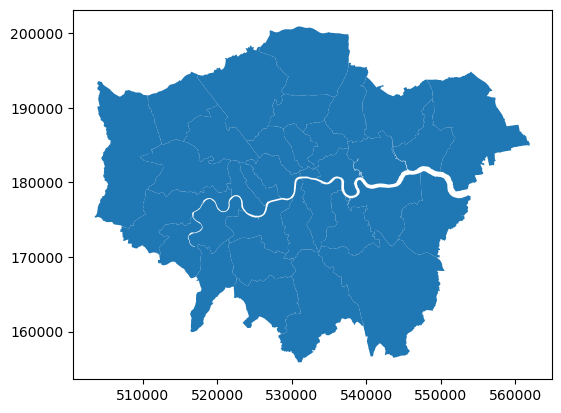

In [7]:
columns=['NAME', 'GSS_CODE', 'geometry']

#Load UK's borough boundaries
boros = gpd.read_file("London_Borough_Excluding_MHW.shp")[columns]

boros.plot()
boros.head()

In [8]:
#Create fire incident points
geometry = [Point(xy) for xy in zip(fires["Easting_rounded"], fires["Northing_rounded"])]
fires_gdf = gpd.GeoDataFrame(fires, geometry=geometry)

#Set fire incidents crs
fires_gdf.set_crs(boros.crs, inplace=True)

,CalYear,IncGeo_BoroughCode,Easting_rounded,Northing_rounded,geometry
309557,2021,E09000009,520050,179850,POINT (520050 179850)
309558,2021,E09000022,530350,176350,POINT (530350 176350)
309607,2021,E09000032,527950,173950,POINT (527950 173950)
309609,2021,E09000033,526350,182550,POINT (526350 182550)
309615,2021,E09000033,525750,181450,POINT (525750 181450)
...,...,...,...,...,...
419007,2021,E09000030,537650,180750,POINT (537650 180750)
419016,2021,E09000011,538350,177650,POINT (538350 177650)
419027,2021,E09000032,527450,174550,POINT (527450 174550)
419060,2021,E09000003,521650,190650,POINT (521650 190650)


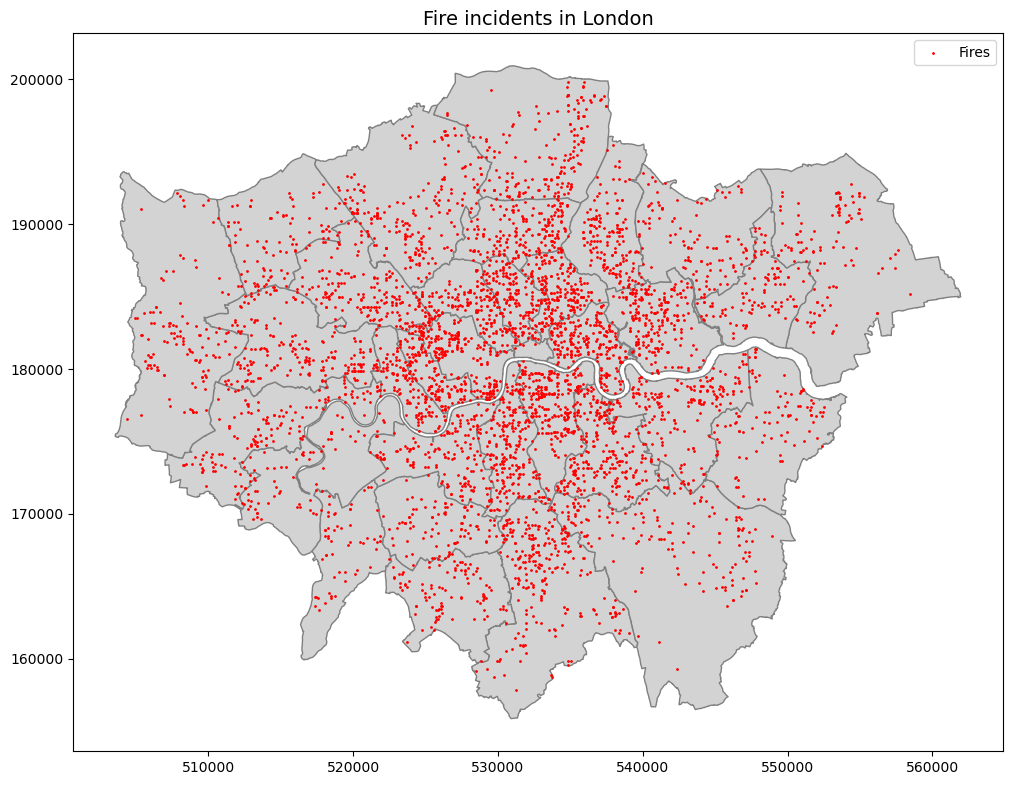

In [9]:
#Set figure
fig, ax = plt.subplots(figsize=(12, 12))

#Plot london boroughs' shapefile
boros.plot(ax=ax, color="lightgrey", edgecolor="grey")

#Plot fire incidents
fires_gdf.plot(ax=ax, color="red", markersize=1, label="Fires")

#Ass info to the graphic
plt.title("Fire incidents in London", fontsize=14)
plt.legend()
plt.show()

Because easting and northing are rounded, it doesn't have enough precision to indicate to which ward it belongs, so fire incidents will be classified by the borough code specified on the csv.

In [10]:
#Count how many fire incidente there are by borough
fire_counts = fires_gdf.groupby('IncGeo_BoroughCode').size().reset_index(name='fire_count')
boros = boros.merge(fire_counts, left_on='GSS_CODE', right_on='IncGeo_BoroughCode', how='left')
boros=boros.drop('IncGeo_BoroughCode', axis=1)

#Fill NAs with zeros
boros['fire_count'] = boros['fire_count'].fillna(0).astype(int)

In [11]:
print(boros['fire_count'].describe())

count     33.000000
mean     148.909091
std       56.595254
min        4.000000
25%      107.000000
50%      159.000000
75%      195.000000
max      240.000000
Name: fire_count, dtype: float64


In [12]:
#Add number of households by LA
columns=['Lower tier local authorities Code', 'Observation']
households=pd.read_csv("TS041-2021-2-filtered-2025-01-19T17_52_49Z.csv", usecols=columns)

boros =boros.merge(households, left_on='GSS_CODE', right_on='Lower tier local authorities Code', how='left')

boros=boros.drop('Lower tier local authorities Code', axis=1)
boros=boros.rename(columns={'Observation':'households'})

#Add fire incidents density(number of incidents by 1000 households)
boros['fires_by_1000households']=boros['fire_count']/boros['households']*1000

boros.head(33)

,NAME,GSS_CODE,geometry,fire_count,households,fires_by_1000households
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",57,65626,0.868558
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",231,152946,1.510337
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",161,135827,1.185331
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",141,102961,1.369451
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",185,133659,1.384119
5,Havering,E09000016,"POLYGON ((549893.9 181459.8, 549894.6 181465.7...",108,101277,1.066382
6,Hillingdon,E09000017,"POLYGON ((510599.8 191689.5, 510615.2 191591.3...",120,109228,1.098619
7,Harrow,E09000015,"POLYGON ((510599.8 191689.5, 510660 191690.9, ...",86,89642,0.959372
8,Brent,E09000005,"POLYGON ((525201 182512.6, 525181.5 182521.1, ...",185,118612,1.559707
9,Barnet,E09000003,"POLYGON ((524579.9 198355.2, 524594.3 198321.4...",195,148917,1.309454


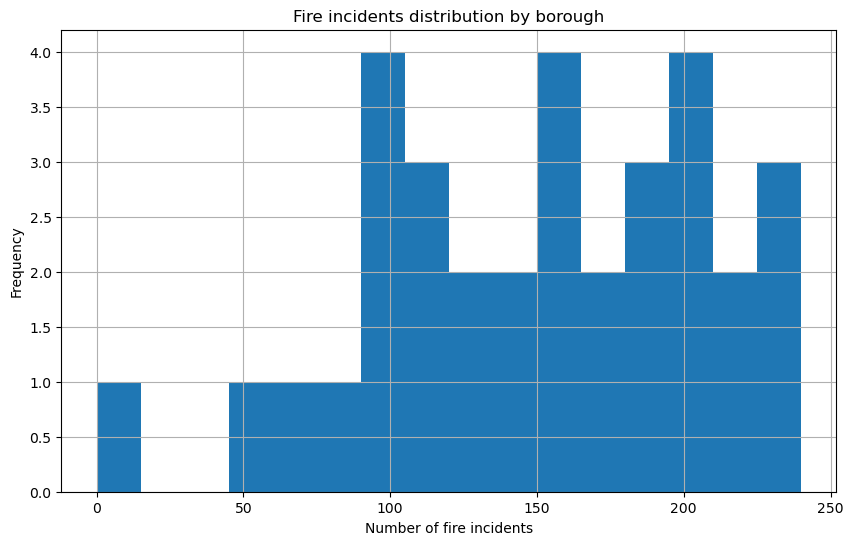

In [13]:
#create histogram
boros['fire_count'].hist(bins=range(0, boros['fire_count'].max() + 15, 15), figsize=(10, 6))

plt.title('Fire incidents distribution by borough')
plt.xlabel('Number of fire incidents')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

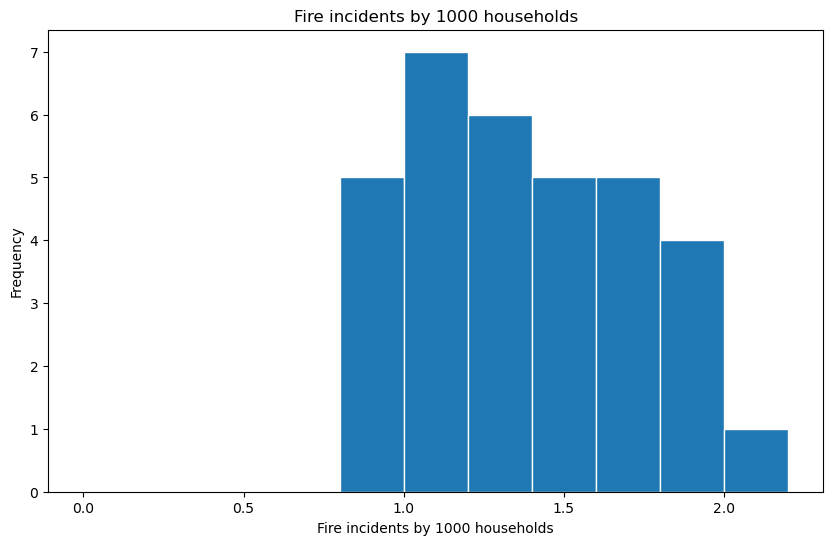

In [14]:
#create histogram
boros['fires_by_1000households'].hist(bins=np.arange(0, boros['fires_by_1000households'].max() + 0.2, 0.2),
                                             figsize=(10, 6),
                                             edgecolor='white')

plt.title('Fire incidents by 1000 households')
plt.xlabel('Fire incidents by 1000 households')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

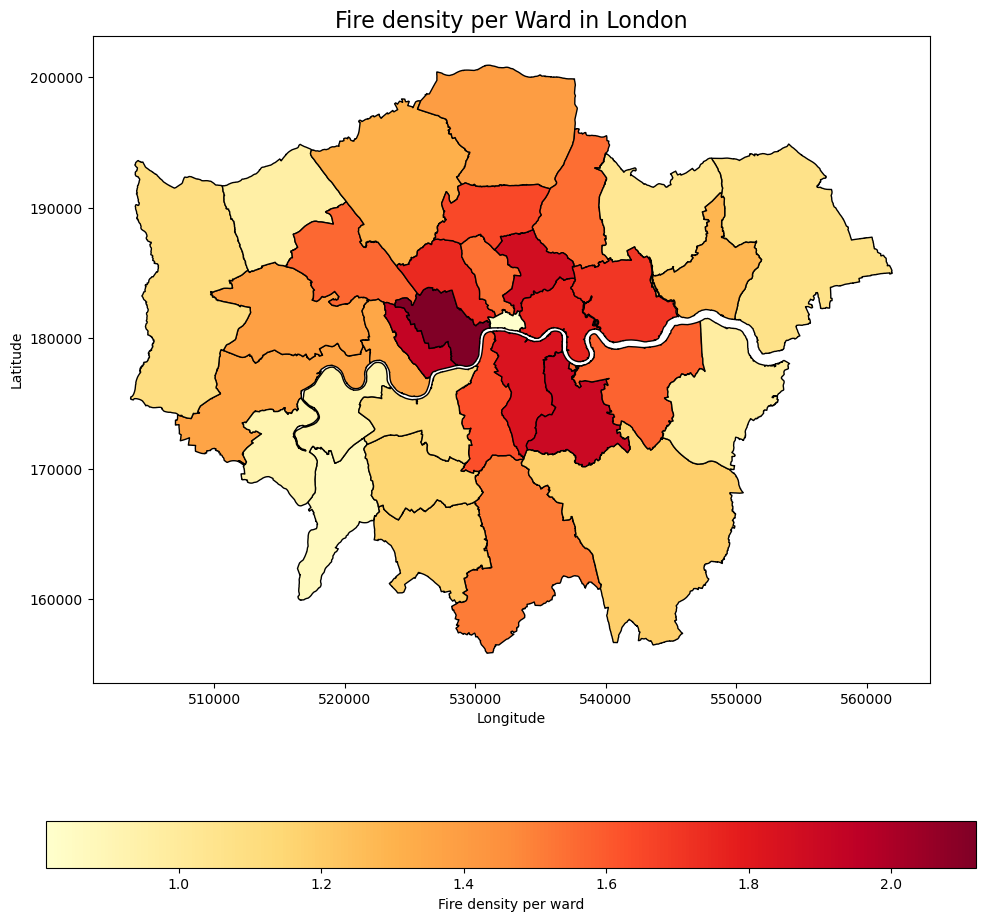

In [15]:
#Plot thematic map on fire incident density
fig, ax = plt.subplots(figsize=(12, 12))

#set thematic map
boros.plot(column='fires_by_1000households', ax=ax, legend=True,
           legend_kwds={'label': "Fire density per ward",
                        'orientation': "horizontal"},
           cmap='YlOrRd',
           edgecolor='black')

plt.title("Fire density per Ward in London", fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [16]:
#Add population density

columns=['Lower tier local authorities Code', 'Observation']
pop_density=pd.read_csv("TS006-2021-3-filtered-2025-01-19T18_03_57Z.csv", usecols=columns)

boros=boros.merge(pop_density, left_on='GSS_CODE', right_on='Lower tier local authorities Code', how='left')

boros=boros.drop('Lower tier local authorities Code', axis=1)
boros.head()

boros=boros.rename(columns={'Observation':'pop_density'})
boros.head()

,NAME,GSS_CODE,geometry,fire_count,households,fires_by_1000households,pop_density
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",57,65626,0.868558,4512.1
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",231,152946,1.510337,4516.0
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",161,135827,1.185331,2197.7
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",141,102961,1.369451,5148.0
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",185,133659,1.384119,6611.6


In [17]:
#Add deprivation data
deprivation = pd.read_csv("TS011-2021-2-filtered-2025-01-19T18_08_31Z.csv")

#Create a pivot table with deprivation options
pivot_table = deprivation.pivot_table(
    index='Lower tier local authorities Code',
    columns='Household deprivation (6 categories) Code',
    values='Observation',
    aggfunc='sum',
    fill_value=0
)

pivot_table.reset_index(inplace=True)

# Rename columns
pivot_table.rename(columns={
    -8: 'Not applicable',
    1: 'no_deprivation',
    2: '1d_deprivation',
    3: '2d_deprivation',
    4: '3d_deprivation',
    5: '4d_deprivation'
}, inplace=True)

#Merge with london wards df
boros = boros.merge(
    pivot_table,
    left_on='GSS_CODE',
    right_on='Lower tier local authorities Code',
    how='left'  # Left join
)

boros=boros.drop(['Lower tier local authorities Code', 'Not applicable'],axis=1)

#Create a new variable of the sum of all households with at least one dimention deprivation
boros['deprived']=boros[['1d_deprivation','2d_deprivation','3d_deprivation','4d_deprivation']].sum(axis=1) 
boros.head()


,NAME,GSS_CODE,geometry,fire_count,households,fires_by_1000households,pop_density,no_deprivation,1d_deprivation,2d_deprivation,3d_deprivation,4d_deprivation,deprived
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",57,65626,0.868558,4512.1,36639,20274,7045,1552,116,28987
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",231,152946,1.510337,4516.0,73406,51772,21635,5581,552,79540
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",161,135827,1.185331,2197.7,74219,42434,15360,3586,228,61608
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",141,102961,1.369451,5148.0,45406,36270,16488,4377,420,57555
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",185,133659,1.384119,6611.6,61529,45650,20275,5686,518,72129


In [18]:
#Add median income of tax payers data
income= pd.read_excel('income-of-tax-payers.xlsx', sheet_name='Total Income',  header=[0, 1])
income_code = income[('Unnamed: 0_level_0', 'Code')]

income_median = income[('2021-22', 'Median £')]

income = pd.DataFrame({
    'Code': income_code,
    'Median £': income_median
})
income = income.reset_index(drop=True)

#Perform the left join with the 'boros' DataFrame
boros = boros.merge(income, left_on='GSS_CODE', right_on='Code', how='left')

boros=boros.drop('Code',axis=1)
boros=boros.rename(columns={'Median £': 'median_income'})

boros.head()

,NAME,GSS_CODE,geometry,fire_count,households,fires_by_1000households,pop_density,no_deprivation,1d_deprivation,2d_deprivation,3d_deprivation,4d_deprivation,deprived,median_income
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",57,65626,0.868558,4512.1,36639,20274,7045,1552,116,28987,35900.0
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",231,152946,1.510337,4516.0,73406,51772,21635,5581,552,79540,30400.0
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",161,135827,1.185331,2197.7,74219,42434,15360,3586,228,61608,35800.0
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",141,102961,1.369451,5148.0,45406,36270,16488,4377,420,57555,29300.0
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",185,133659,1.384119,6611.6,61529,45650,20275,5686,518,72129,30900.0


In [19]:
#Add unemployment data

unemployment= pd.read_csv('unemployment-by-local-authorities.csv')

unemployment= unemployment[
    (unemployment['time'] == 'Jan2021-Dec2021') &
    (unemployment['ethnicity'] == 'All') &
    (unemployment['ethnicity_type'] == 'All')
]
unemployment= unemployment[['Geography', 'value']]

# Perform left join
boros = boros.merge(
    unemployment,
    how='left',
    left_on='NAME',
    right_on='Geography'
)
boros.rename(columns={'value': 'unemployment'}, inplace=True)

boros.drop(columns=['Geography'], inplace=True)

boros['unemployment'].replace('?', np.nan, inplace=True)

/tmp/ipykernel_70032/3426220834.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  boros['unemployment'].replace('?', np.nan, inplace=True)


In [20]:
#Add tenure data
tenure=pd.read_csv('TS054-2021-3-filtered-2025-01-19T19_32_43Z.csv')

#Create a pivot table with tenure options
pivot_table = tenure.pivot_table(
    index='Lower tier local authorities Code',
    columns='Tenure of household (9 categories) Code',
    values='Observation',
    aggfunc='sum',
    fill_value=0
)

pivot_table.reset_index(inplace=True)

#Group and rename columns
pivot_table['owns'] = pivot_table[0] + pivot_table[1] + pivot_table[2]
pivot_table['rents'] = pivot_table[3] + pivot_table[4] + pivot_table[5]+ pivot_table[6]
pivot_table['other'] = pivot_table[7] + pivot_table[-8]

#Select useful columns
pivot_table=pivot_table[['Lower tier local authorities Code', 'owns', 'rents']]

#Perform left join with the boros dataFrame
boros = boros.merge(pivot_table, left_on='GSS_CODE', right_on='Lower tier local authorities Code', how='left')
boros=boros.drop('Lower tier local authorities Code', axis=1)
boros.head()

,NAME,GSS_CODE,geometry,fire_count,households,fires_by_1000households,pop_density,no_deprivation,1d_deprivation,2d_deprivation,3d_deprivation,4d_deprivation,deprived,median_income,unemployment,owns,rents
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",57,65626,0.868558,4512.1,36639,20274,7045,1552,116,28987,35900.0,3.1,40397,25155
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",231,152946,1.510337,4516.0,73406,51772,21635,5581,552,79540,30400.0,5.9,85850,66812
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",161,135827,1.185331,2197.7,74219,42434,15360,3586,228,61608,35800.0,6.4,94194,41587
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",141,102961,1.369451,5148.0,45406,36270,16488,4377,420,57555,29300.0,4.5,49269,53406
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",185,133659,1.384119,6611.6,61529,45650,20275,5686,518,72129,30900.0,6.8,64472,68872


In [21]:
#Add socioeconomic variables as %
boros['%owns']=boros['owns']/boros['households']*100 
boros['%rents']=boros['rents']/boros['households']*100 
boros['%deprived']=boros['deprived']/boros['households']*100
boros['%1d_deprived']=boros['1d_deprivation']/boros['households']*100
boros['%2d_deprived']=boros['2d_deprivation']/boros['households']*100
boros['%3d_deprived']=boros['3d_deprivation']/boros['households']*100
boros['%4d_deprived']=boros['4d_deprivation']/boros['households']*100
boros['%notdeprived']=boros['no_deprivation']/boros['households']*100

boros.head(33)

,NAME,GSS_CODE,geometry,fire_count,households,fires_by_1000households,pop_density,no_deprivation,1d_deprivation,2d_deprivation,...,owns,rents,%owns,%rents,%deprived,%1d_deprived,%2d_deprived,%3d_deprived,%4d_deprived,%notdeprived
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",57,65626,0.868558,4512.1,36639,20274,7045,...,40397,25155,61.556395,38.330844,44.169994,30.893244,10.735075,2.364916,0.176759,55.830006
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",231,152946,1.510337,4516.0,73406,51772,21635,...,85850,66812,56.130922,43.683392,52.005283,33.849856,14.145515,3.649000,0.360912,47.994717
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",161,135827,1.185331,2197.7,74219,42434,15360,...,94194,41587,69.348510,30.617624,45.357698,31.241211,11.308503,2.640123,0.167861,54.642302
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",141,102961,1.369451,5148.0,45406,36270,16488,...,49269,53406,47.852099,51.870126,55.899807,35.226931,16.013830,4.251124,0.407921,44.100193
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",185,133659,1.384119,6611.6,61529,45650,20275,...,64472,68872,48.236183,51.528143,53.964941,34.154079,15.169199,4.254109,0.387553,46.034311
5,Havering,E09000016,"POLYGON ((549893.9 181459.8, 549894.6 181465.7...",108,101277,1.066382,2332.3,47903,34966,14859,...,71355,29826,70.455286,29.449924,52.701008,34.525114,14.671643,3.294924,0.209327,47.298992
6,Hillingdon,E09000017,"POLYGON ((510599.8 191689.5, 510615.2 191591.3...",120,109228,1.098619,2644.0,50136,38207,16448,...,63204,45889,57.864284,42.012121,54.099681,34.979126,15.058410,3.762771,0.299374,45.900319
7,Harrow,E09000015,"POLYGON ((510599.8 191689.5, 510660 191690.9, ...",86,89642,0.959372,5175.4,43681,30953,12012,...,53697,35793,59.901609,39.928828,51.271725,34.529573,13.399969,3.082261,0.259923,48.728275
8,Brent,E09000005,"POLYGON ((525201 182512.6, 525181.5 182521.1, ...",185,118612,1.559707,7859.6,47376,43300,21017,...,47839,70602,40.332344,59.523488,60.058004,36.505581,17.719118,5.335042,0.498263,39.941996
9,Barnet,E09000003,"POLYGON ((524579.9 198355.2, 524594.3 198321.4...",195,148917,1.309454,4488.7,73825,49136,19877,...,80040,68739,53.748061,46.159270,50.428091,32.995561,13.347704,3.636254,0.448572,49.574595


In [22]:
#Select only key columns for regression
columns=['NAME', 'GSS_CODE', 'geometry', 'fires_by_1000households', 'pop_density', 'median_income', 'unemployment', '%owns', '%rents', '%1d_deprived', '%2d_deprived', '%3d_deprived', '%4d_deprived', '%notdeprived']

boros_regression=boros[columns]
boros_regression.head()
print(boros_regression.dtypes)

NAME                         object
GSS_CODE                     object
geometry                   geometry
fires_by_1000households     float64
pop_density                 float64
median_income               float64
unemployment                 object
%owns                       float64
%rents                      float64
%1d_deprived                float64
%2d_deprived                float64
%3d_deprived                float64
%4d_deprived                float64
%notdeprived                float64
dtype: object


In [23]:
boros_regression['unemployment']=boros_regression['unemployment'].astype(float)

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [24]:
print(boros_regression.dtypes)

NAME                         object
GSS_CODE                     object
geometry                   geometry
fires_by_1000households     float64
pop_density                 float64
median_income               float64
unemployment                float64
%owns                       float64
%rents                      float64
%1d_deprived                float64
%2d_deprived                float64
%3d_deprived                float64
%4d_deprived                float64
%notdeprived                float64
dtype: object


In [25]:
#Check normality of each value
normality_results = {}

#Exclude the three first columns
columns_to_plot = boros_regression.iloc[:, 3:].columns

# Evaluar normalidad para cada columna del DataFrame
for column in columns_to_plot:
    data = boros_regression[column].dropna()
    
    # Realizar la prueba de Shapiro-Wilk
    stat, p_value = shapiro(data)
        
    # Guardar el resultado
    normality_results[column] = {
        'statistic': stat,
        'p_value': p_value,
        'is_normal': p_value > 0.05  # True si es normal, False si no
        }
    
results_df = pd.DataFrame.from_dict(normality_results, orient='index')
print(results_df)

                         statistic   p_value  is_normal
fires_by_1000households   0.972870  0.563345       True
pop_density               0.942987  0.083001       True
median_income             0.759173  0.000006      False
unemployment              0.969124  0.475569       True
%owns                     0.945821  0.100432       True
%rents                    0.945827  0.100471       True
%1d_deprived              0.977971  0.723319       True
%2d_deprived              0.967499  0.414415       True
%3d_deprived              0.973640  0.586833       True
%4d_deprived              0.958165  0.229256       True
%notdeprived              0.969911  0.477736       True


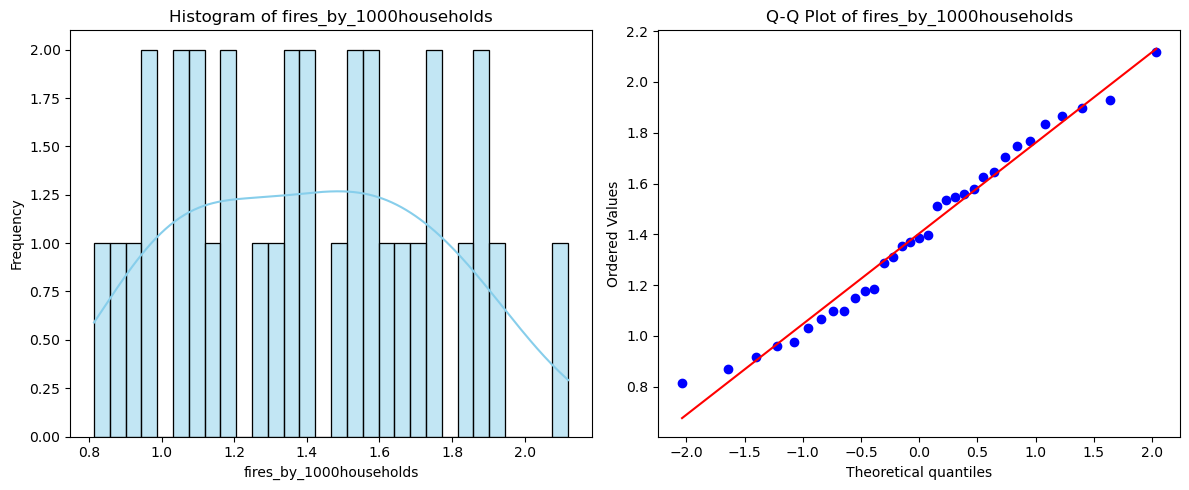

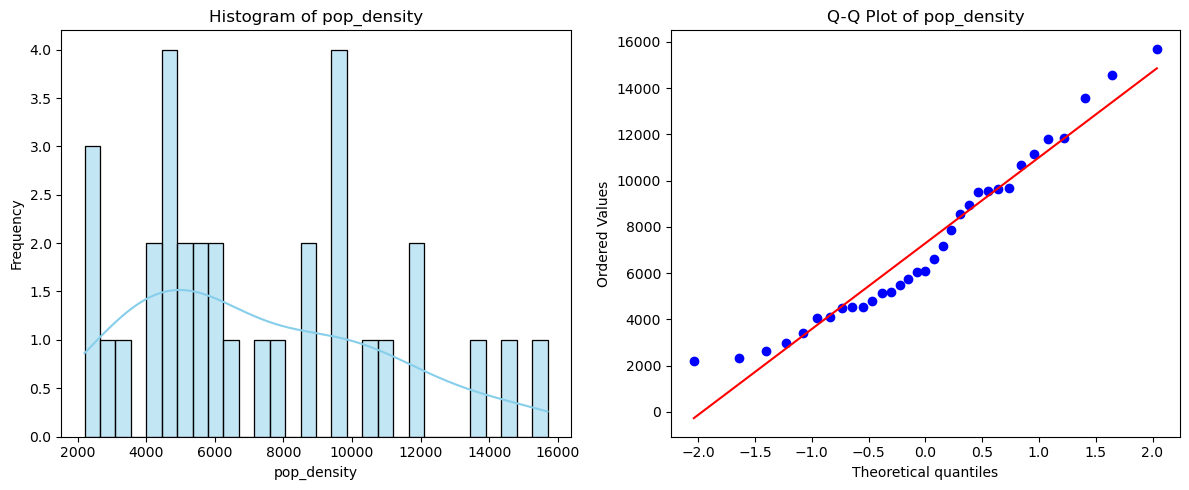

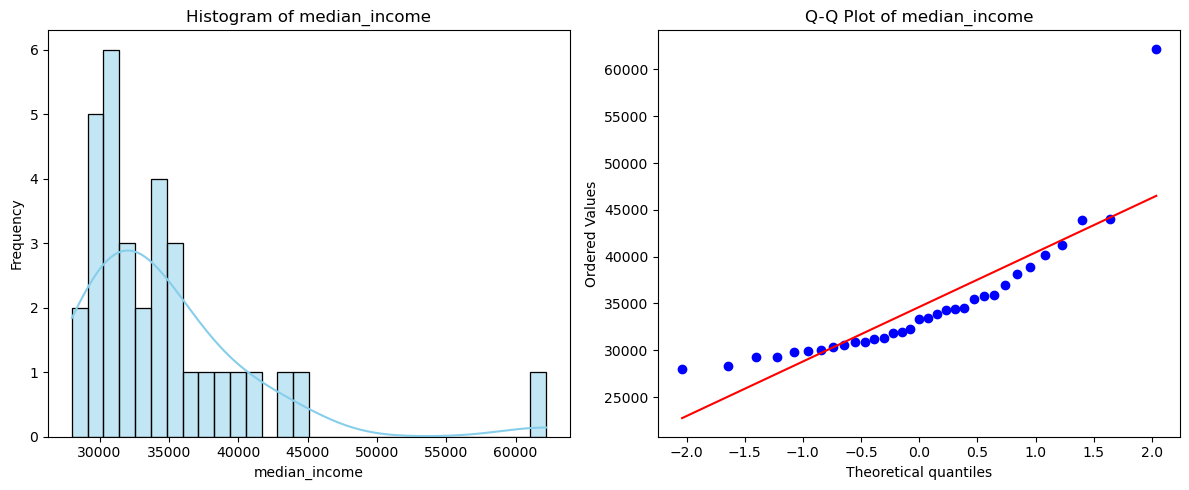

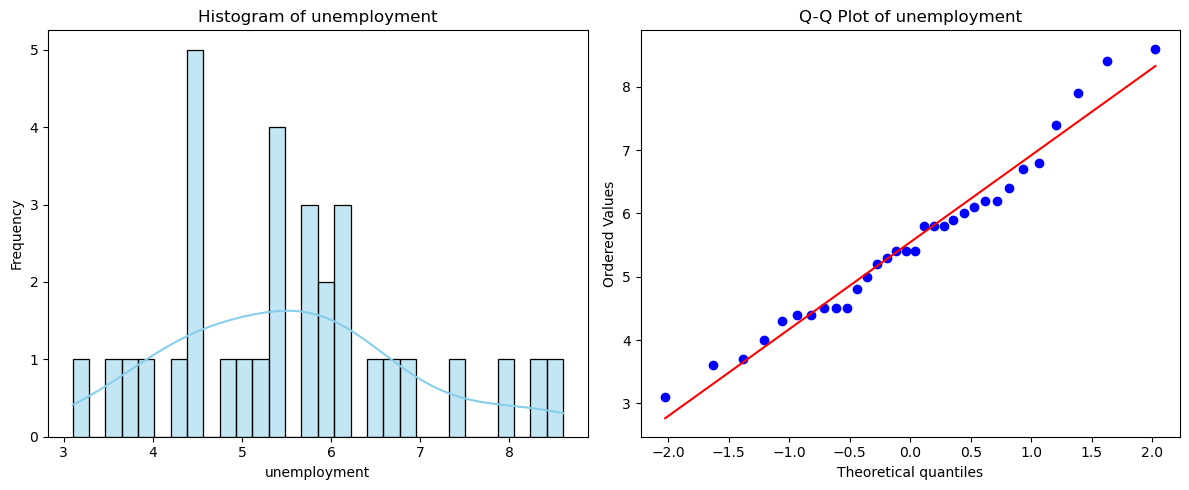

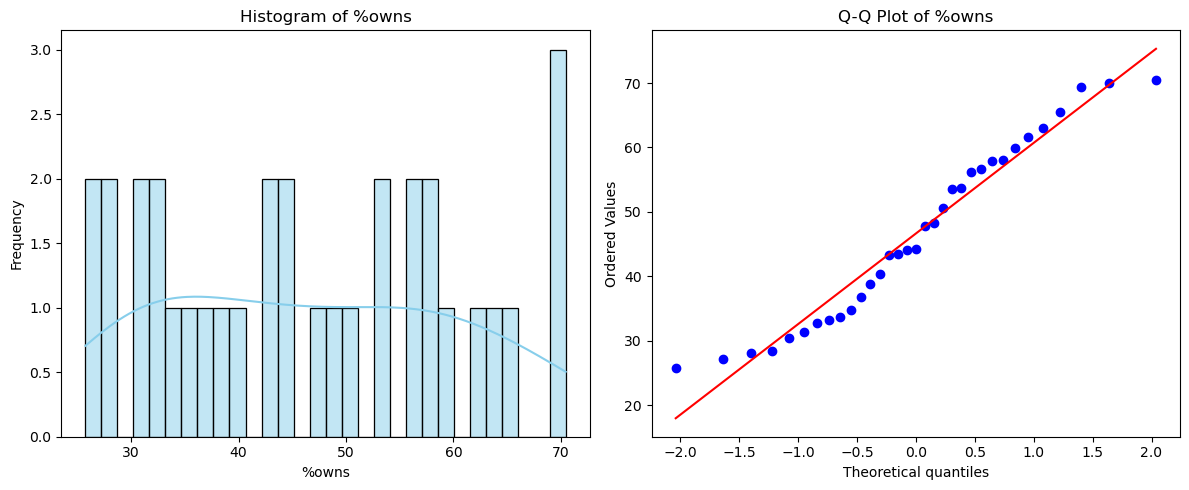

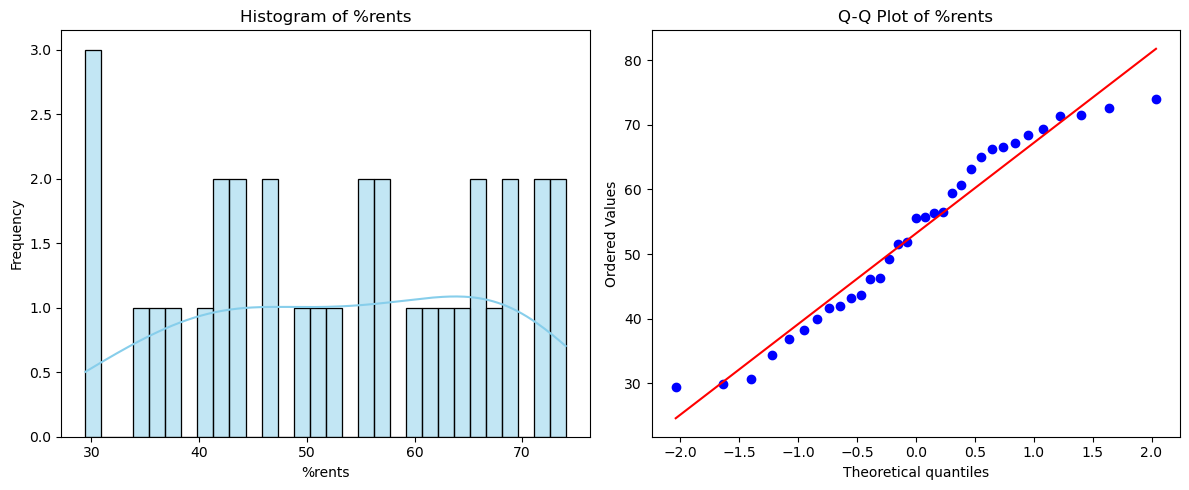

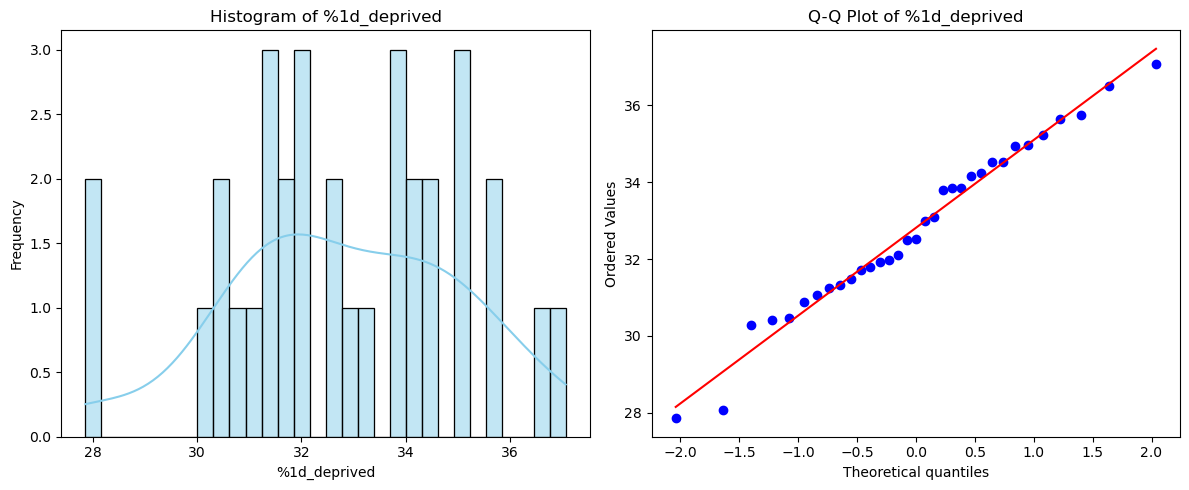

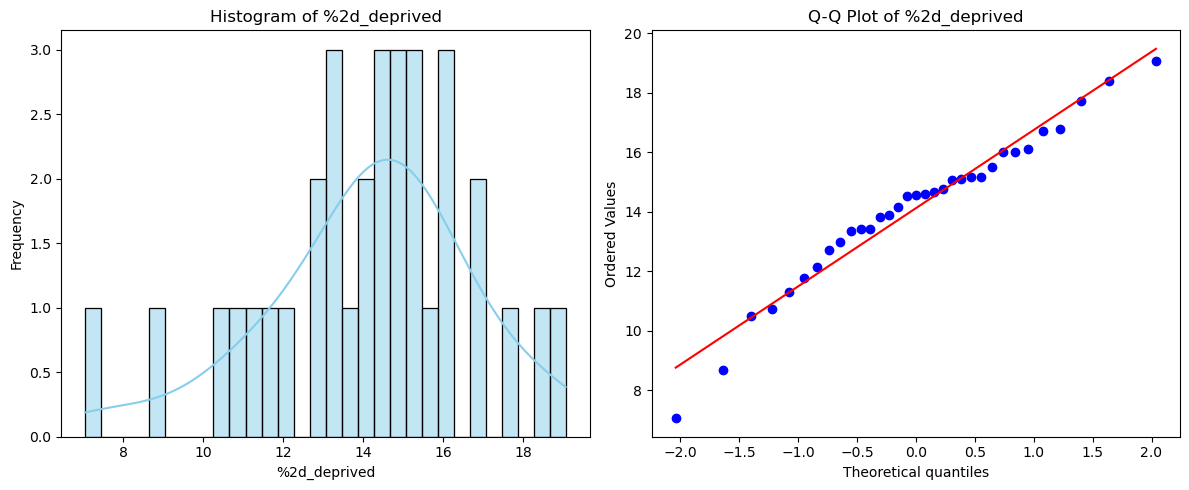

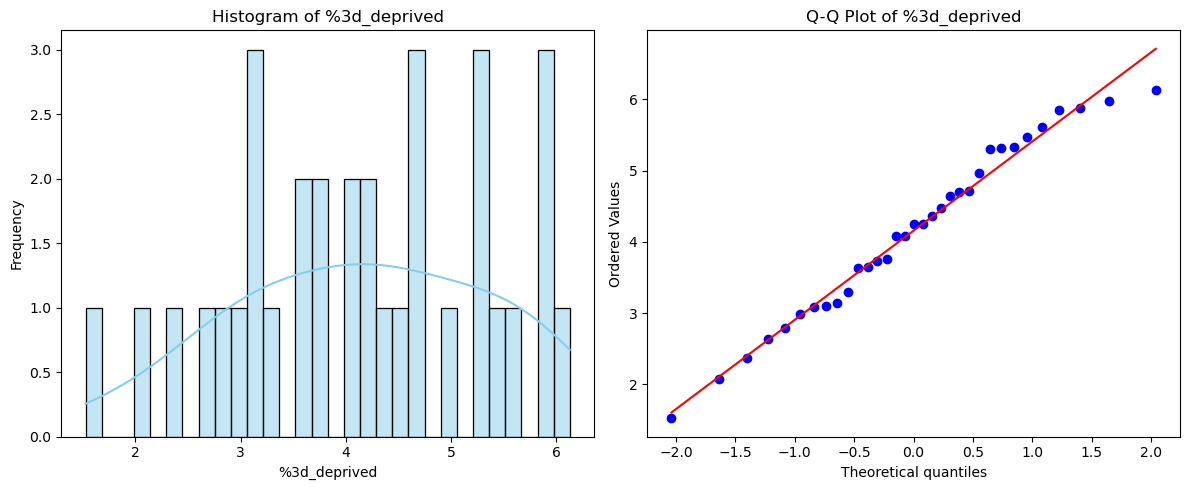

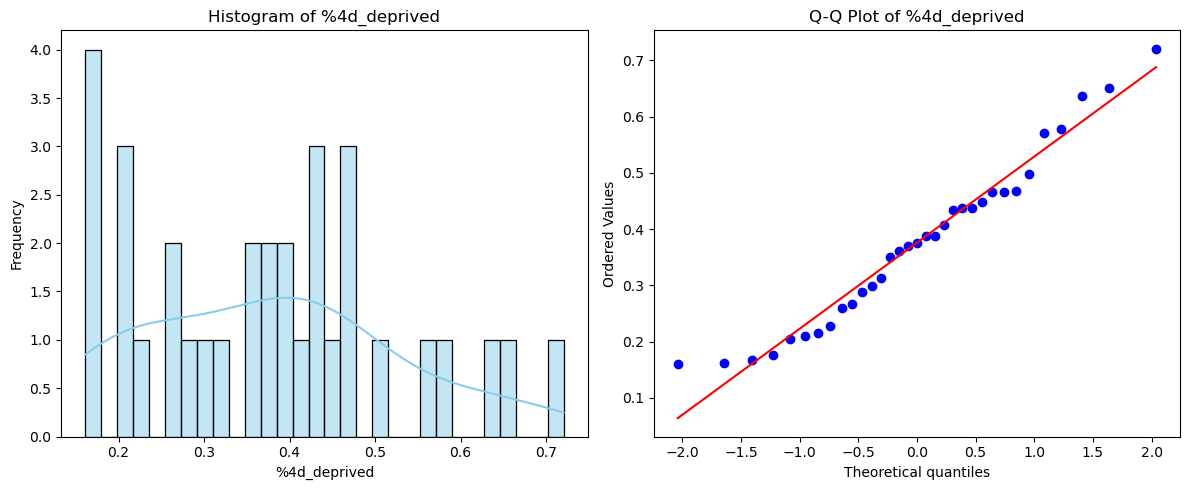

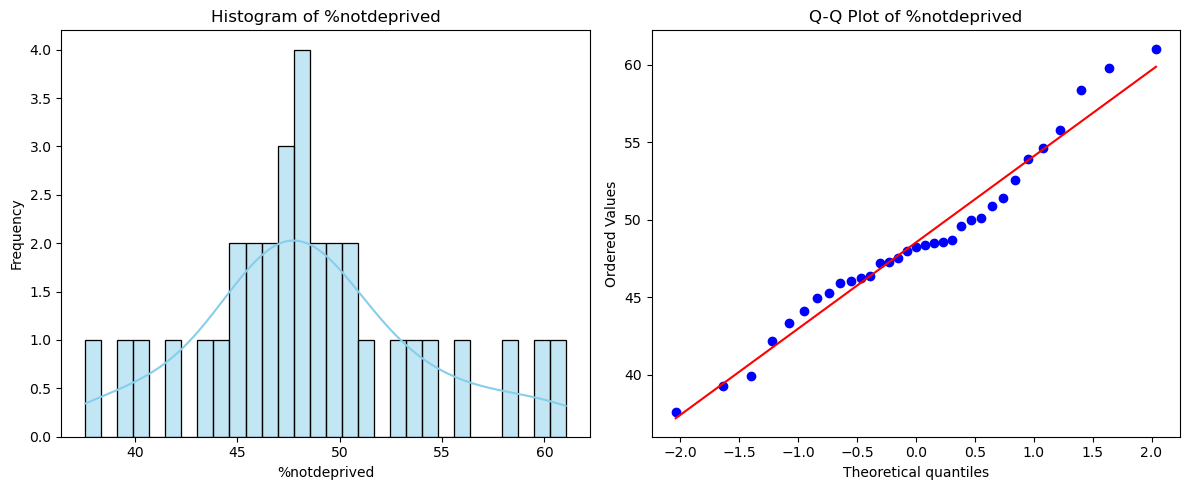

In [26]:
for column in columns_to_plot:
    plt.figure(figsize=(12, 5))
        
        # Histograma
    plt.subplot(1, 2, 1)
    sns.histplot(boros_regression[column].dropna().astype(float), kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
        
        # Q-Q Plot
    plt.subplot(1, 2, 2)
    probplot(boros_regression[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {column}')
        
    plt.tight_layout()
    plt.show()

In [27]:
# Encontrar el índice de la fila con el valor máximo en 'median_income'
max_value_idx = boros_regression['median_income'].idxmax()

# Obtener el valor máximo de 'median_income' y el valor correspondiente en 'NAME'
max_value = boros_regression.loc[max_value_idx, 'median_income']
corresponding_name = boros_regression.loc[max_value_idx, 'NAME']

print(f"El valor máximo de 'median_income' es {max_value} y corresponde a '{corresponding_name}'")

El valor máximo de 'median_income' es 62200.0 y corresponde a 'City of London'


In [28]:
#Considering City of London is an outlier on the median_income column and also has NA values in unemployment, it will be retired from the analysis
boros_regression = boros_regression.drop(boros_regression[boros_regression['NAME'] == 'City of London'].index)

In [29]:
boros_regression.head(33)

,NAME,GSS_CODE,geometry,fires_by_1000households,pop_density,median_income,unemployment,%owns,%rents,%1d_deprived,%2d_deprived,%3d_deprived,%4d_deprived,%notdeprived
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",0.868558,4512.1,35900.0,3.1,61.556395,38.330844,30.893244,10.735075,2.364916,0.176759,55.830006
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",1.510337,4516.0,30400.0,5.9,56.130922,43.683392,33.849856,14.145515,3.649000,0.360912,47.994717
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",1.185331,2197.7,35800.0,6.4,69.348510,30.617624,31.241211,11.308503,2.640123,0.167861,54.642302
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",1.369451,5148.0,29300.0,4.5,47.852099,51.870126,35.226931,16.013830,4.251124,0.407921,44.100193
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",1.384119,6611.6,30900.0,6.8,48.236183,51.528143,34.154079,15.169199,4.254109,0.387553,46.034311
5,Havering,E09000016,"POLYGON ((549893.9 181459.8, 549894.6 181465.7...",1.066382,2332.3,29800.0,5.4,70.455286,29.449924,34.525114,14.671643,3.294924,0.209327,47.298992
6,Hillingdon,E09000017,"POLYGON ((510599.8 191689.5, 510615.2 191591.3...",1.098619,2644.0,30600.0,6.7,57.864284,42.012121,34.979126,15.058410,3.762771,0.299374,45.900319
7,Harrow,E09000015,"POLYGON ((510599.8 191689.5, 510660 191690.9, ...",0.959372,5175.4,32300.0,5.8,59.901609,39.928828,34.529573,13.399969,3.082261,0.259923,48.728275
8,Brent,E09000005,"POLYGON ((525201 182512.6, 525181.5 182521.1, ...",1.559707,7859.6,30000.0,7.9,40.332344,59.523488,36.505581,17.719118,5.335042,0.498263,39.941996
9,Barnet,E09000003,"POLYGON ((524579.9 198355.2, 524594.3 198321.4...",1.309454,4488.7,33500.0,7.4,53.748061,46.159270,32.995561,13.347704,3.636254,0.448572,49.574595


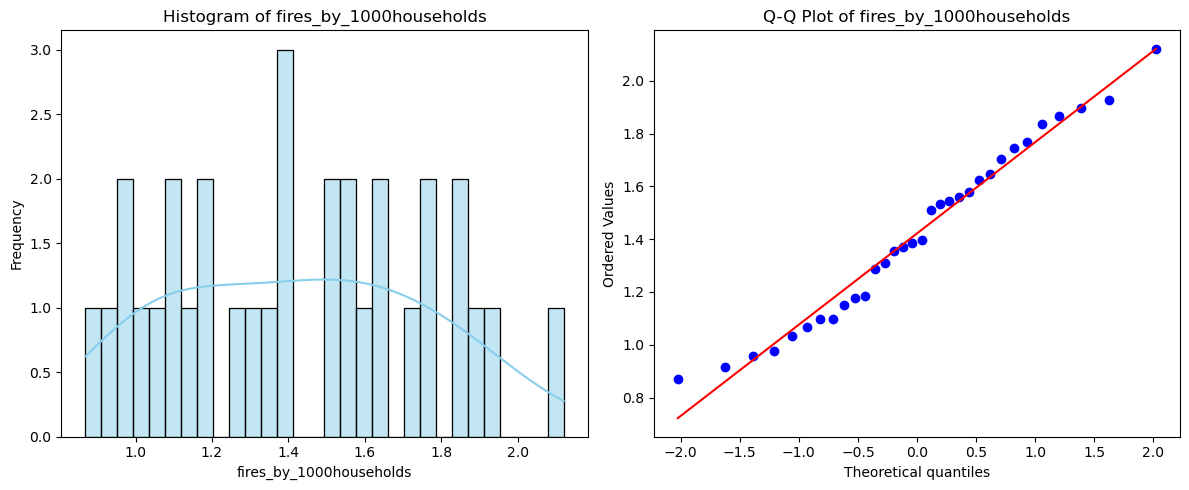

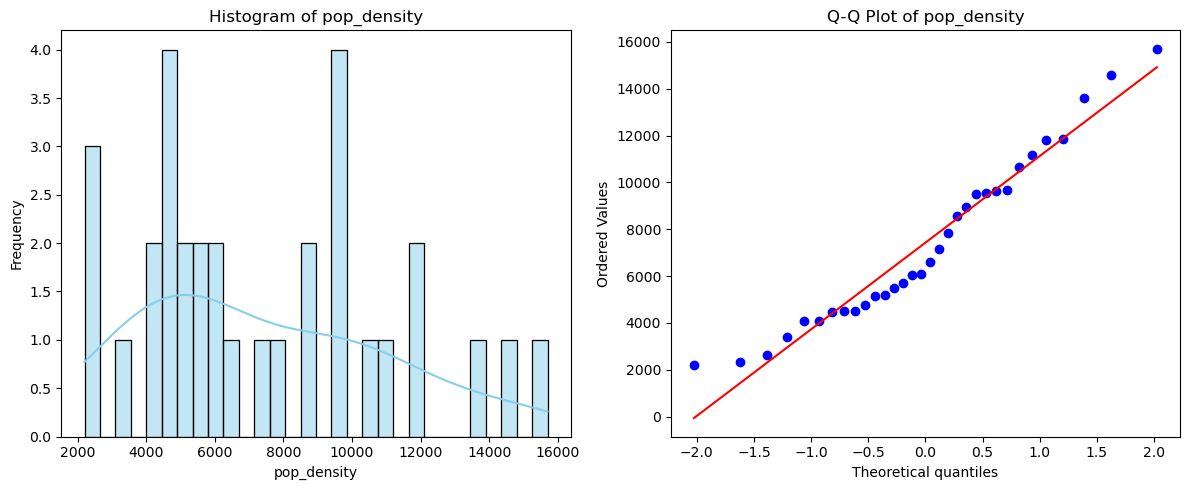

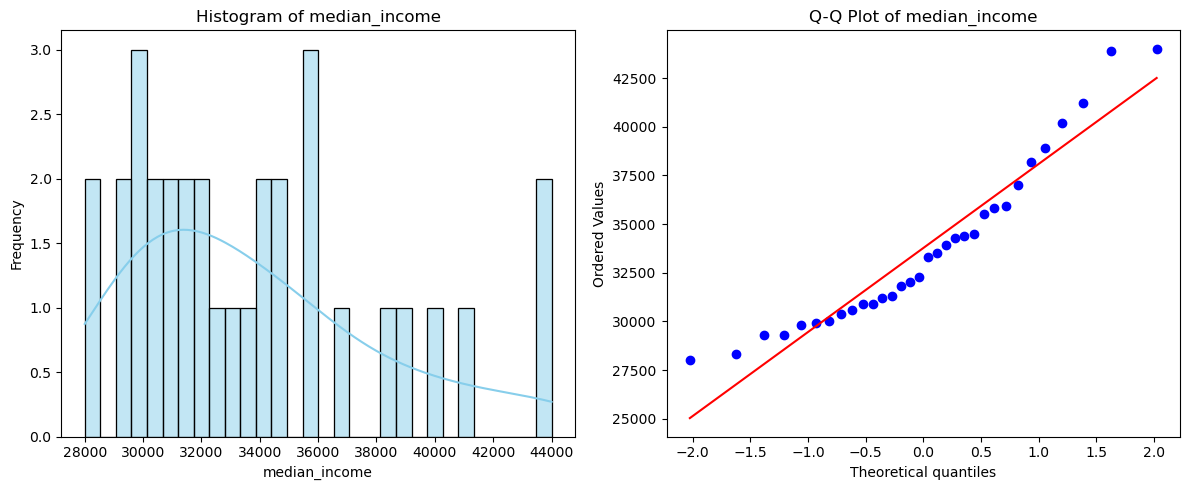

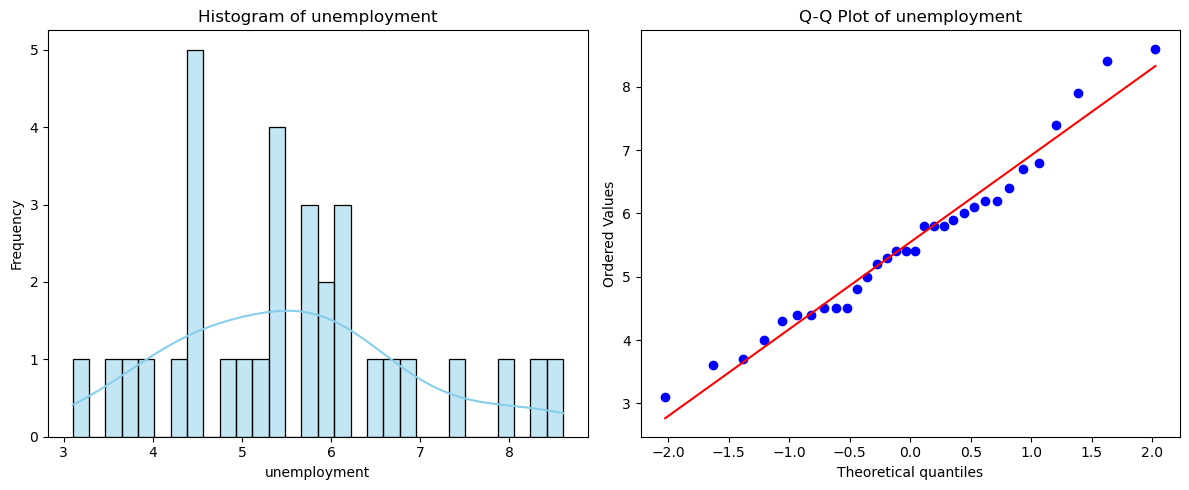

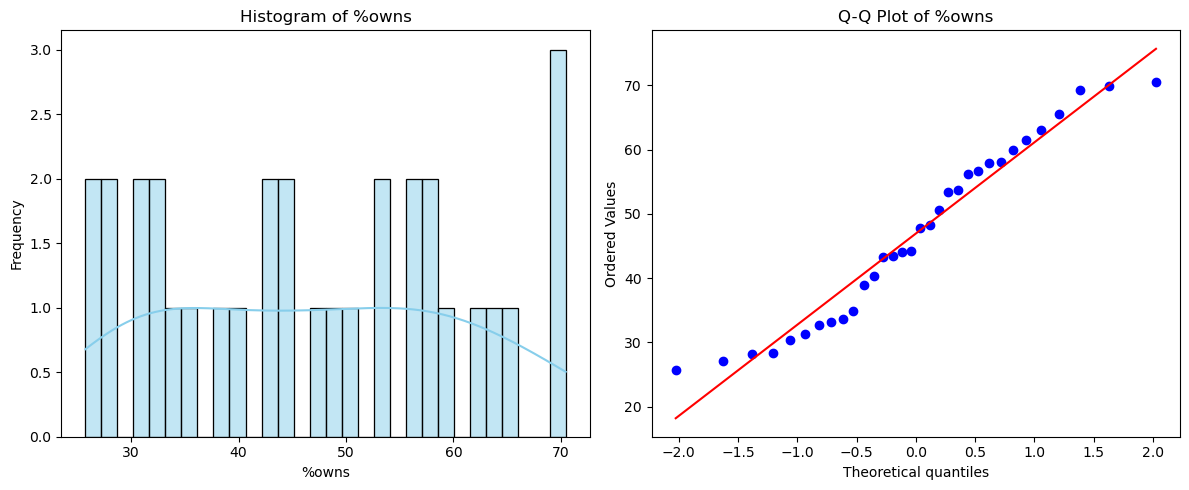

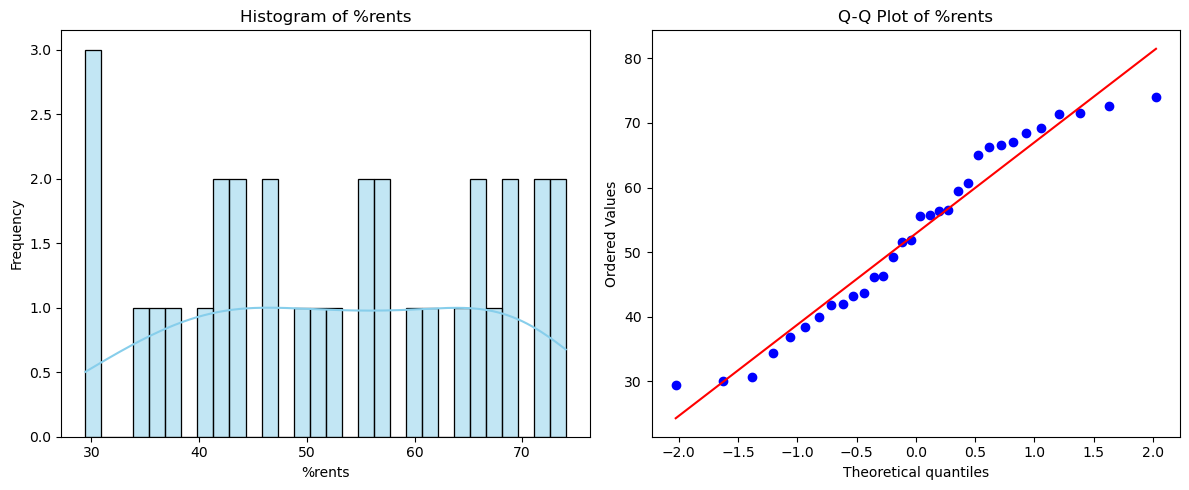

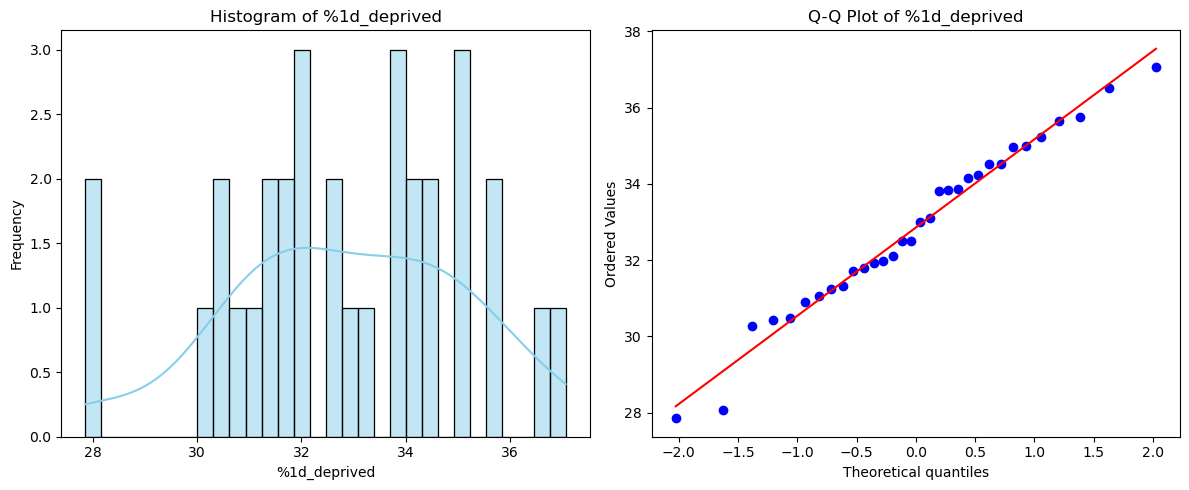

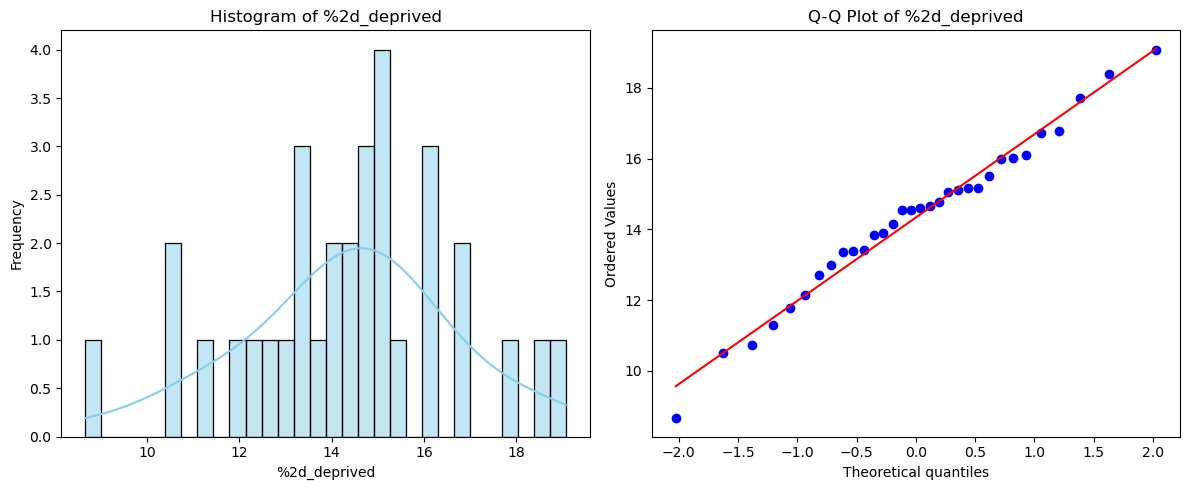

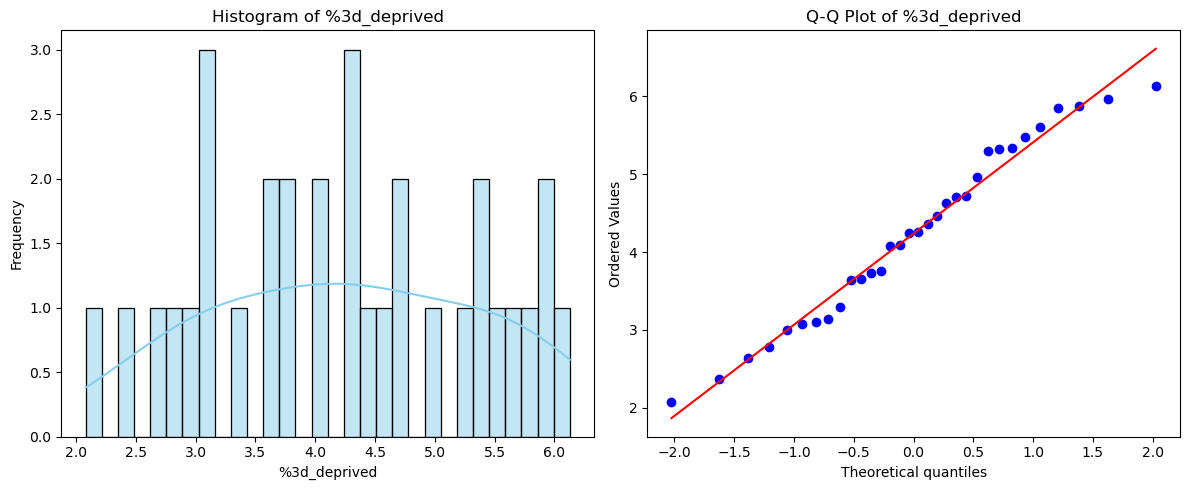

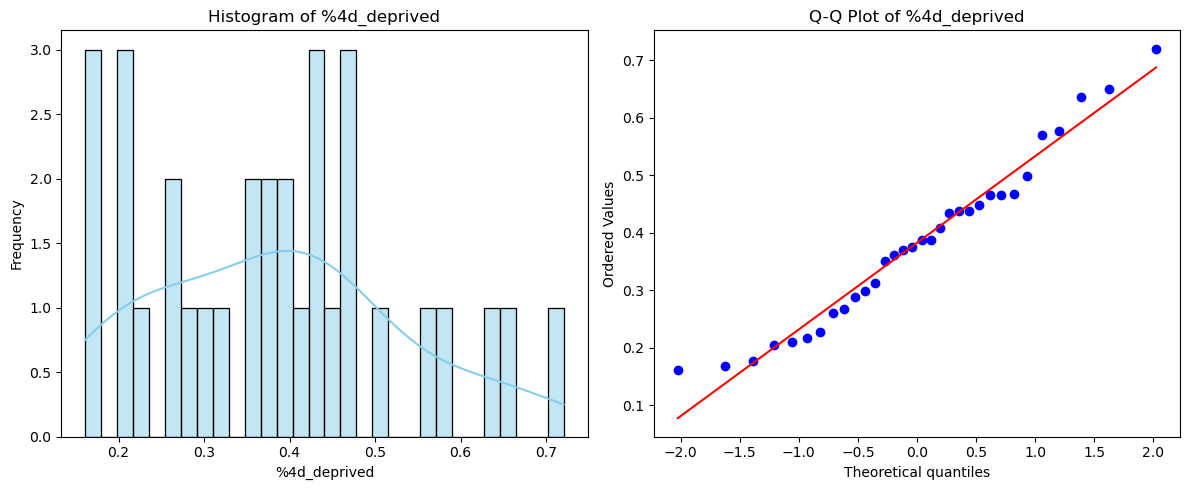

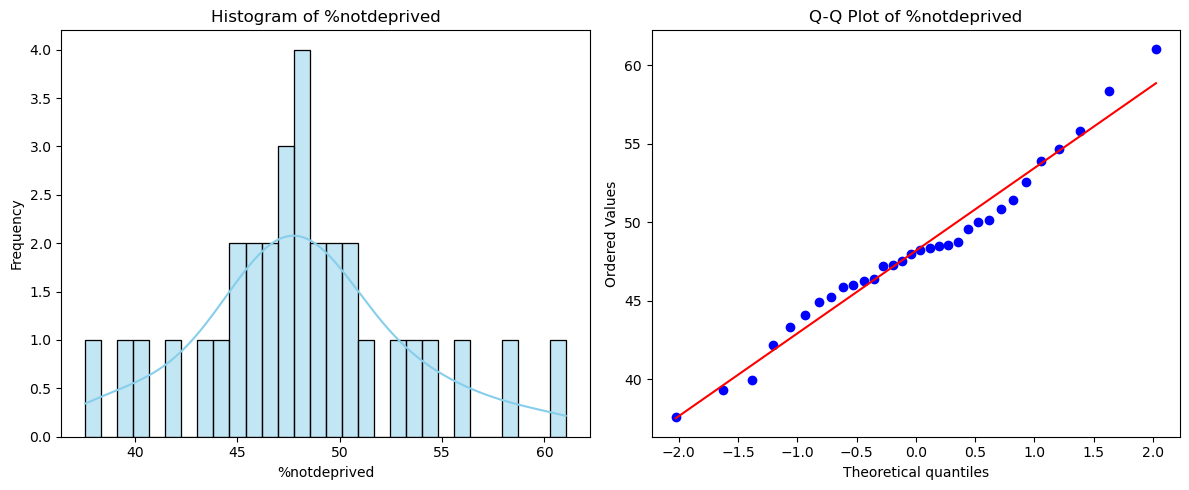

                         statistic   p_value  is_normal
fires_by_1000households   0.972870  0.563345       True
pop_density               0.942987  0.083001       True
median_income             0.759173  0.000006      False
unemployment              0.969124  0.475569       True
%owns                     0.945821  0.100432       True
%rents                    0.945827  0.100471       True
%1d_deprived              0.977971  0.723319       True
%2d_deprived              0.967499  0.414415       True
%3d_deprived              0.973640  0.586833       True
%4d_deprived              0.958165  0.229256       True
%notdeprived              0.969911  0.477736       True


In [30]:
normality_results2 = {}

for column in columns_to_plot:
    plt.figure(figsize=(12, 5))
        
    # Histograma
    plt.subplot(1, 2, 1)
    sns.histplot(boros_regression[column].dropna().astype(float), kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
        
    # Q-Q Plot
    plt.subplot(1, 2, 2)
    probplot(boros_regression[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {column}')
        
    plt.tight_layout()
    plt.show()

    data = boros_regression[column].dropna()
    
    # Realizar la prueba de Shapiro-Wilk
    stat, p_value = shapiro(data)
        
    # Guardar el resultado
    normality_results2[column] = {
        'statistic': stat,
        'p_value': p_value,
        'is_normal': p_value > 0.05  # True si es normal, False si no
        }
    
results_df2 = pd.DataFrame.from_dict(normality_results2, orient='index')
print(results_df)  

In [31]:
#I will log median_income in order to normalize it
boros_regression['log_median_income'] = np.log(boros_regression['median_income'])

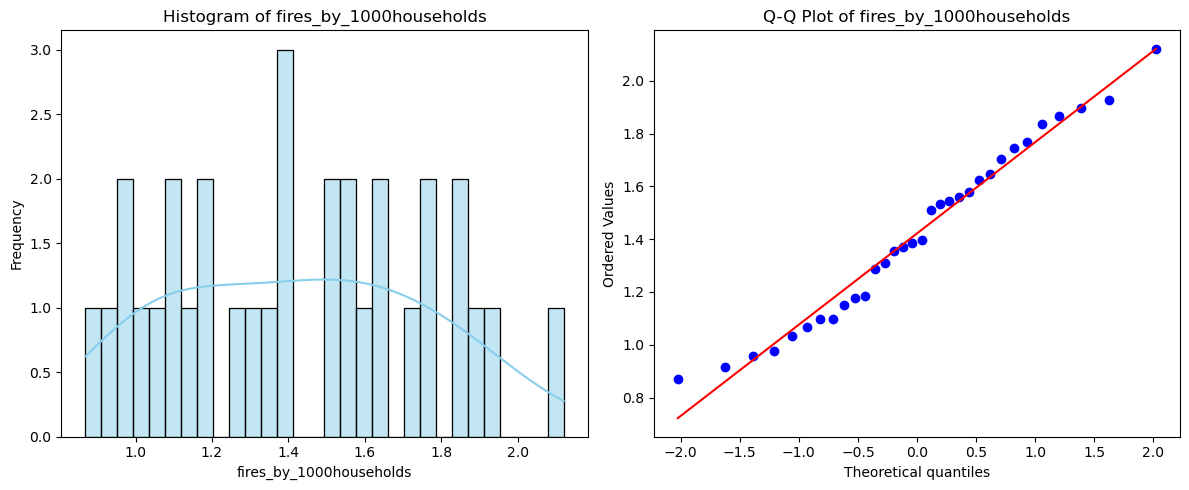

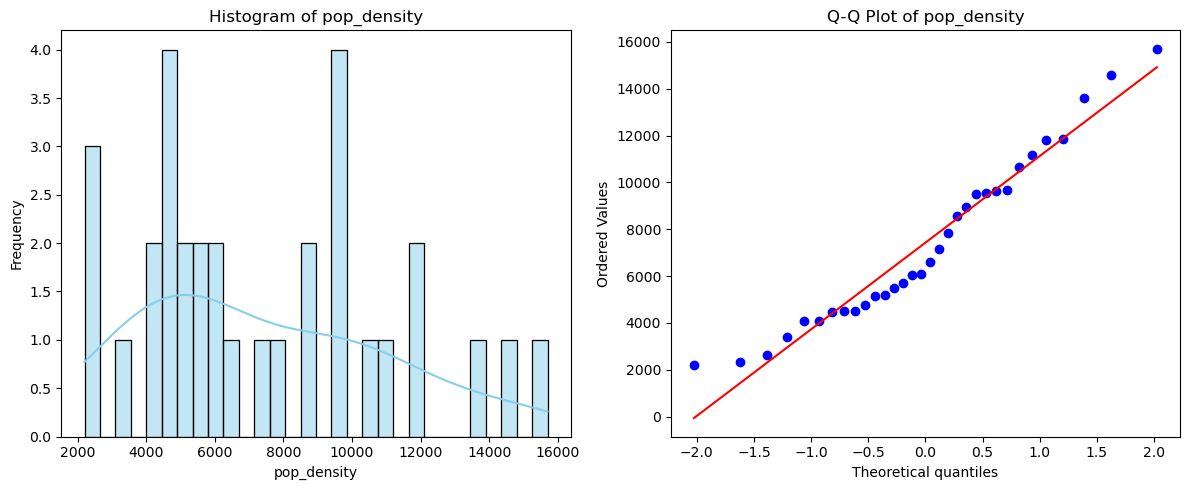

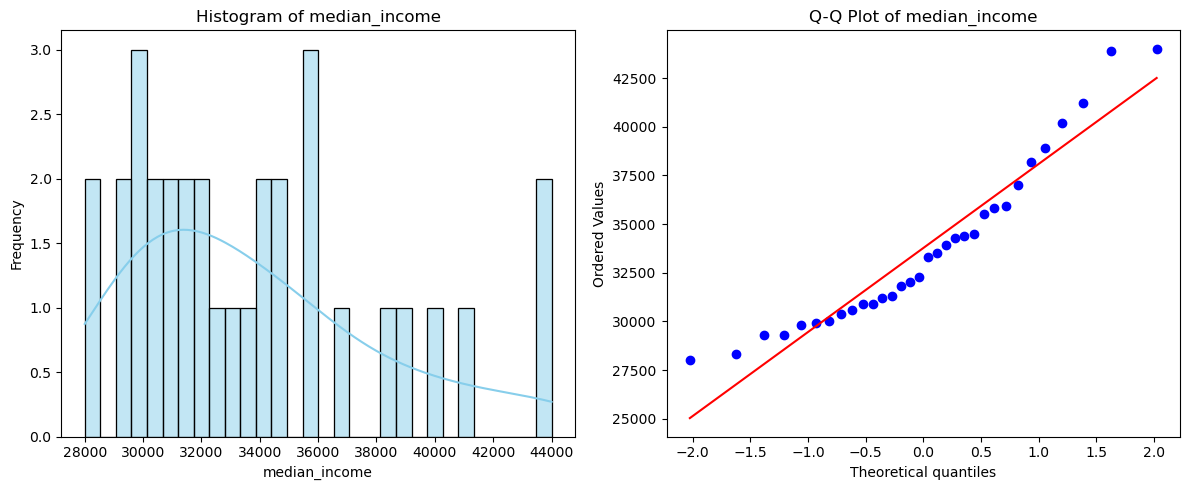

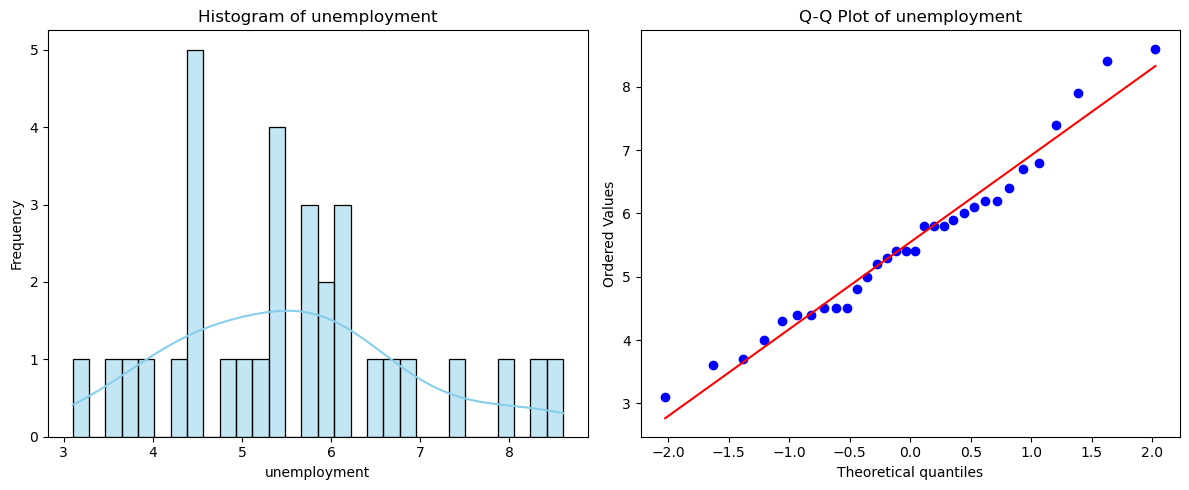

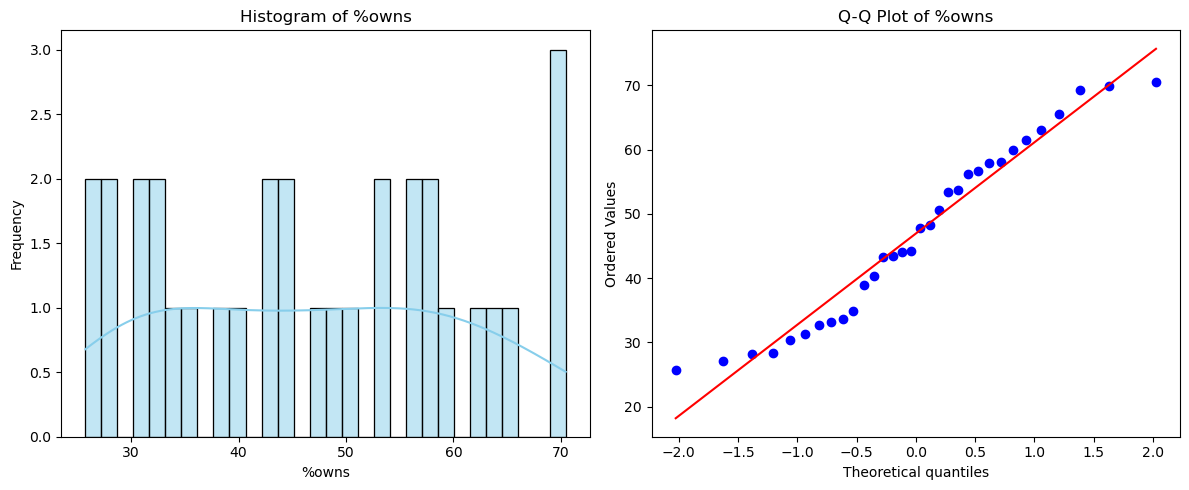

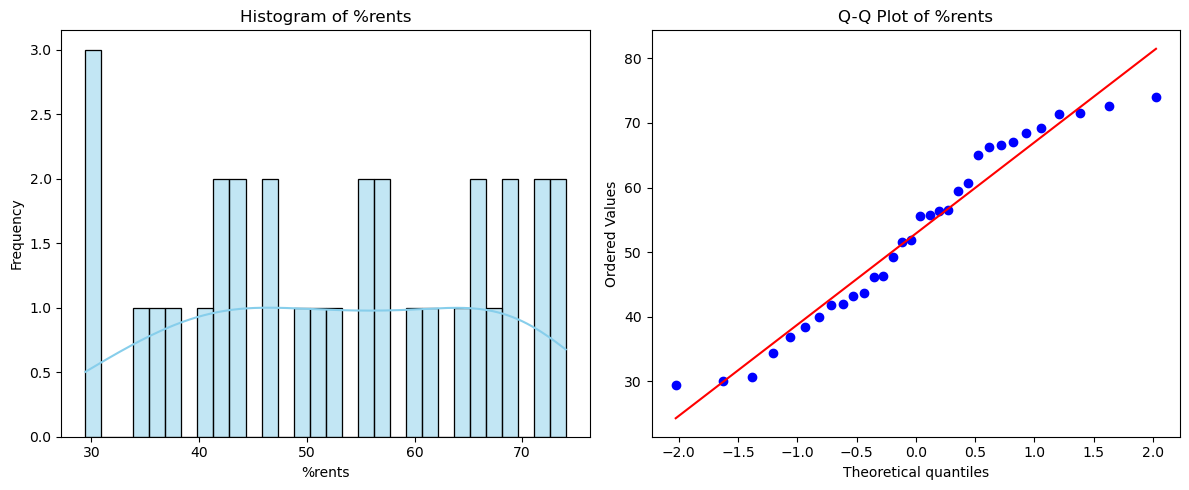

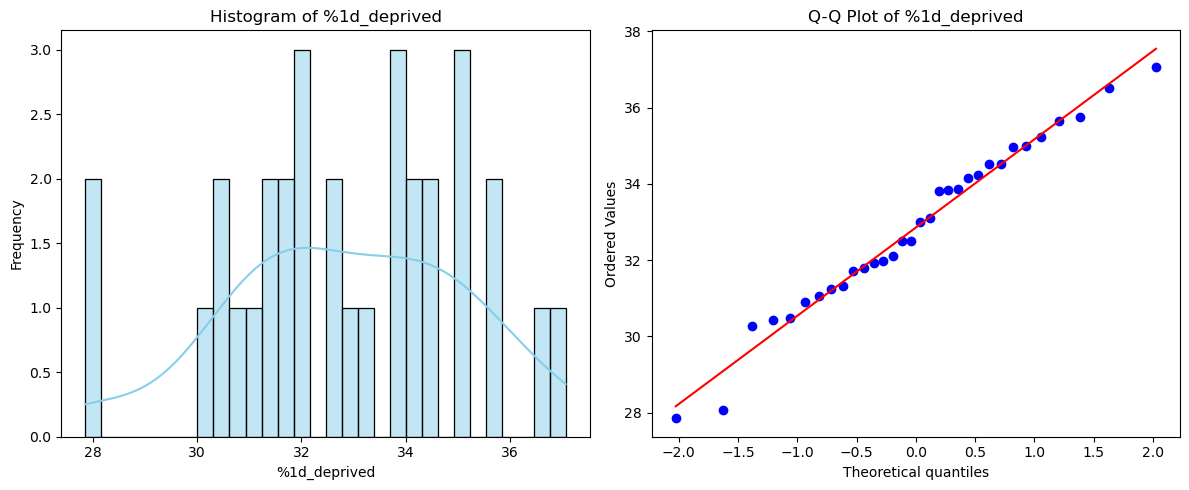

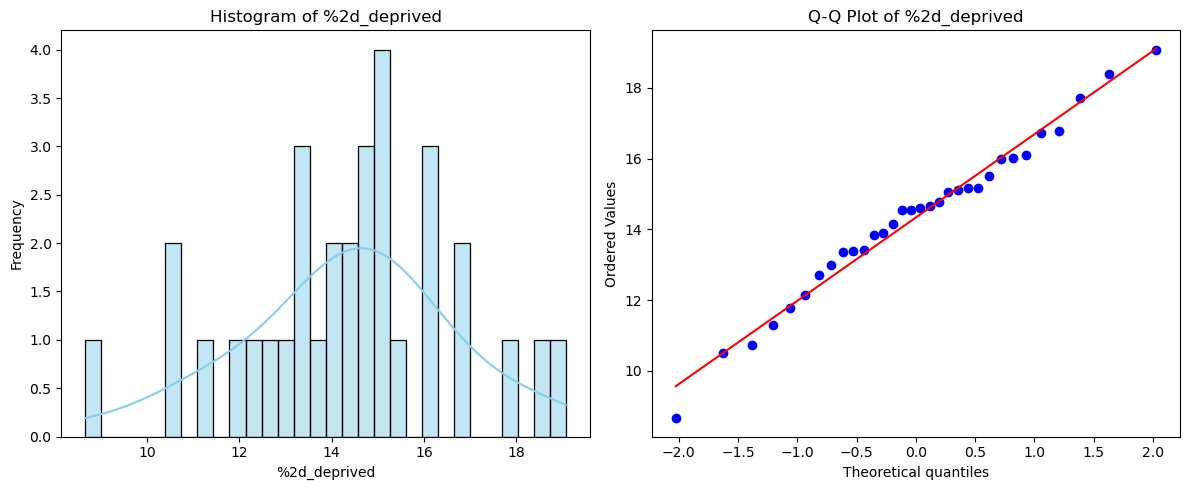

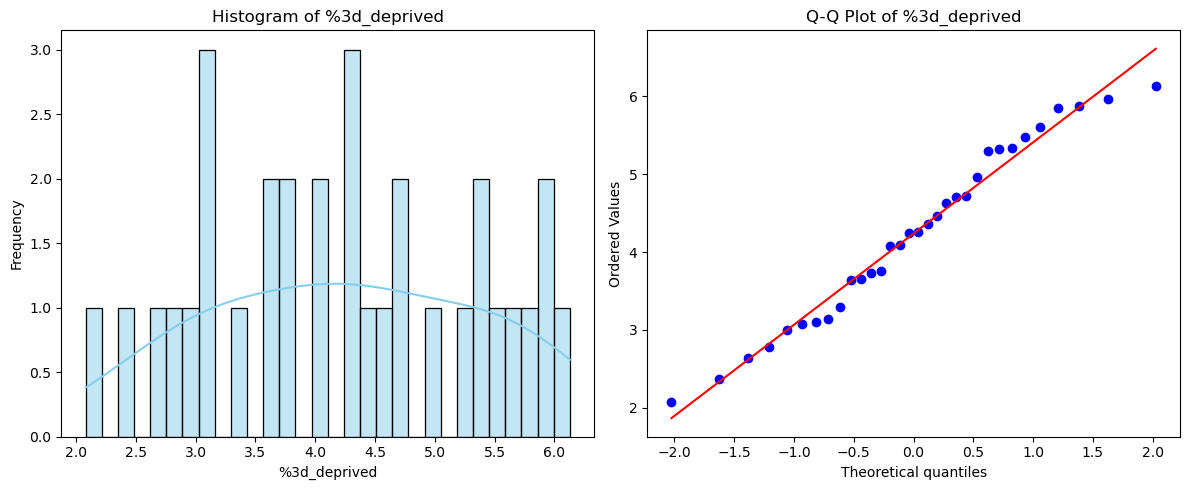

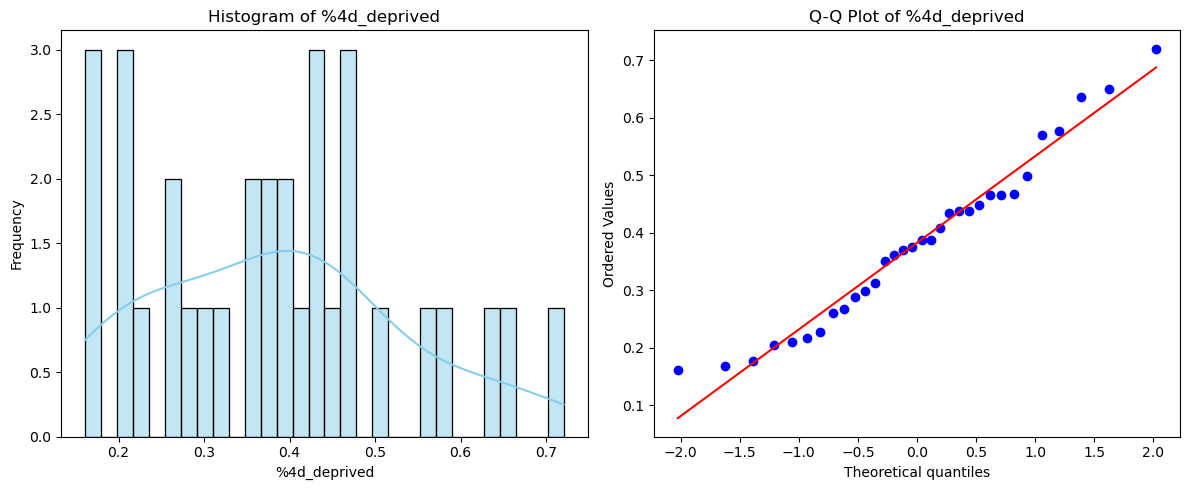

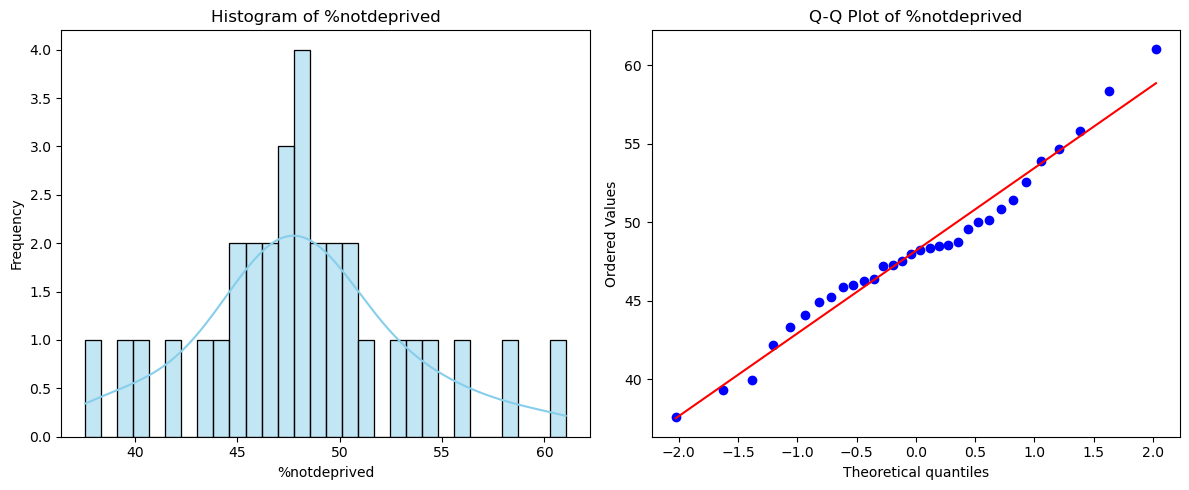

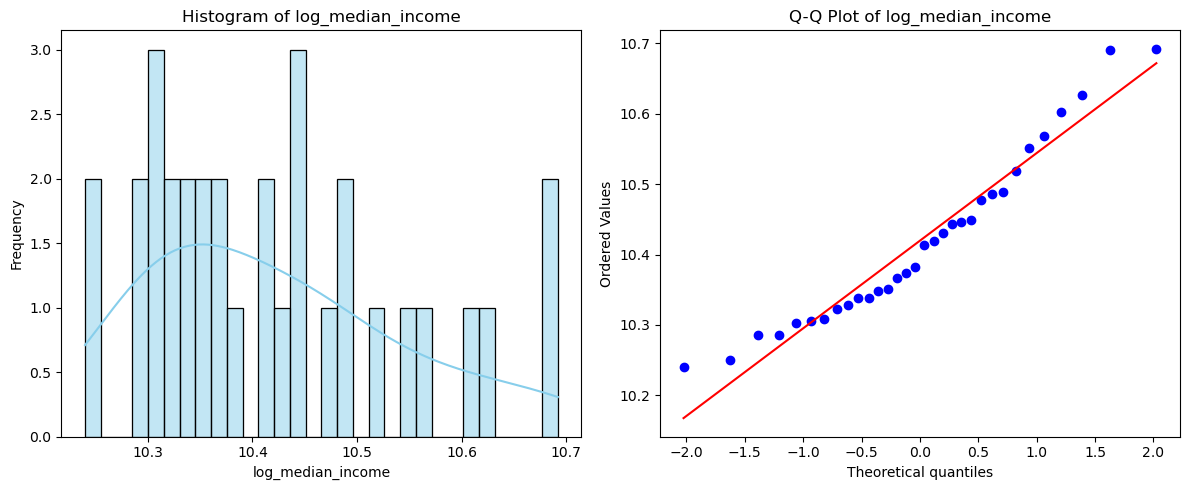

                         statistic   p_value  is_normal
fires_by_1000households   0.970342  0.508904       True
pop_density               0.947011  0.118502       True
median_income             0.914997  0.015246      False
unemployment              0.969124  0.475569       True
%owns                     0.944973  0.103677       True
%rents                    0.945079  0.104401       True
%1d_deprived              0.978007  0.739912       True
%2d_deprived              0.985991  0.942868       True
%3d_deprived              0.967265  0.427531       True
%4d_deprived              0.963012  0.331331       True
%notdeprived              0.976494  0.693185       True
log_median_income         0.939789  0.073842       True


In [32]:
normality_results3 = {}

#Exclude the three first columns
columns_to_plot = boros_regression.iloc[:, 3:].columns

for column in columns_to_plot:
    plt.figure(figsize=(12, 5))
        
    # Histograma
    plt.subplot(1, 2, 1)
    sns.histplot(boros_regression[column].dropna().astype(float), kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
        
    # Q-Q Plot
    plt.subplot(1, 2, 2)
    probplot(boros_regression[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {column}')
        
    plt.tight_layout()
    plt.show()

    data = boros_regression[column].dropna()
    
    # Realizar la prueba de Shapiro-Wilk
    stat, p_value = shapiro(data)
        
    # Guardar el resultado
    normality_results3[column] = {
        'statistic': stat,
        'p_value': p_value,
        'is_normal': p_value > 0.05  # True si es normal, False si no
        }
    
results_df3 = pd.DataFrame.from_dict(normality_results3, orient='index')
print(results_df3)

In [33]:
boros_regression= boros_regression[['NAME', 'GSS_CODE', 'geometry', 'fires_by_1000households',
       'pop_density', 'unemployment', '%owns', '%rents', '%1d_deprived','%2d_deprived', '%3d_deprived', '%4d_deprived', '%notdeprived','log_median_income']]

In [34]:
boros_regression.head()

,NAME,GSS_CODE,geometry,fires_by_1000households,pop_density,unemployment,%owns,%rents,%1d_deprived,%2d_deprived,%3d_deprived,%4d_deprived,%notdeprived,log_median_income
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",0.868558,4512.1,3.1,61.556395,38.330844,30.893244,10.735075,2.364916,0.176759,55.830006,10.488493
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",1.510337,4516.0,5.9,56.130922,43.683392,33.849856,14.145515,3.649000,0.360912,47.994717,10.322198
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",1.185331,2197.7,6.4,69.348510,30.617624,31.241211,11.308503,2.640123,0.167861,54.642302,10.485703
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",1.369451,5148.0,4.5,47.852099,51.870126,35.226931,16.013830,4.251124,0.407921,44.100193,10.285343
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",1.384119,6611.6,6.8,48.236183,51.528143,34.154079,15.169199,4.254109,0.387553,46.034311,10.338511


In [35]:
print(boros_regression.corr(numeric_only=True))

                         fires_by_1000households  pop_density  unemployment  \
fires_by_1000households                 1.000000     0.698859     -0.104417   
pop_density                             0.698859     1.000000     -0.249797   
unemployment                           -0.104417    -0.249797      1.000000   
%owns                                  -0.829452    -0.909563      0.194538   
%rents                                  0.829354     0.910149     -0.194401   
%1d_deprived                           -0.067149    -0.322906      0.188332   
%2d_deprived                            0.407095     0.209056      0.057540   
%3d_deprived                            0.767724     0.650441     -0.076946   
%4d_deprived                            0.822832     0.605431     -0.121211   
%notdeprived                           -0.345533    -0.113267     -0.087479   
log_median_income                       0.170674     0.382495     -0.229383   

                            %owns    %rents  %1d_de

Text(0.5, 1.0, 'Correlation Matrix')

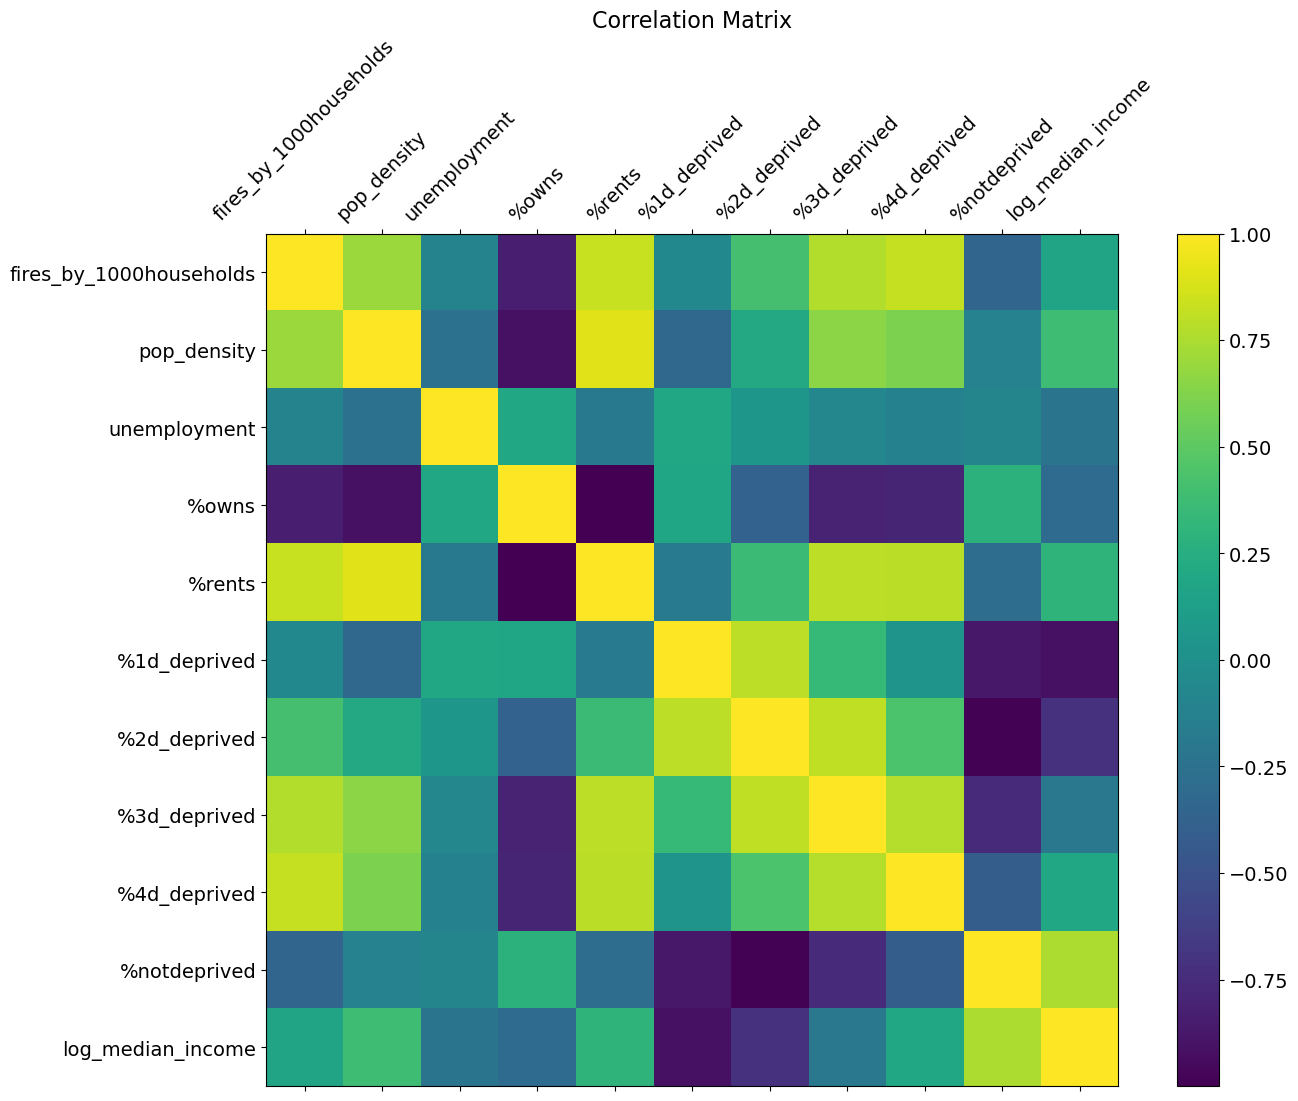

In [36]:
correlation_columns = boros_regression.iloc[:, 3:]

f = plt.figure(figsize=(15, 11)) # creates a new figure, sets length and width
plt.matshow(correlation_columns.corr(), fignum=f.number) # matshow - creates matrix plot for df_office.corr(), fignum - assigned number for when there is multiple figures plotted
# if you are using pandas 2.1, use the following code to replace the above line
# plt.matshow(df_office.corr(numeric_only=True), fignum=f.number)
plt.xticks(range(correlation_columns.select_dtypes(['number']).shape[1]), correlation_columns.select_dtypes(['number']).columns, fontsize=14, rotation=45) # add the x axis label
plt.yticks(range(correlation_columns.select_dtypes(['number']).shape[1]), correlation_columns.select_dtypes(['number']).columns, fontsize=14) # add the y axis label
# select_dtypes(['number']) - choose the numeric variables
cb = plt.colorbar() # add a legend to the right hand (default position)
cb.ax.tick_params(labelsize=14) # label size
plt.title('Correlation Matrix', fontsize=16) # add the title

In [37]:
#Define VIF Function
def drop_column_using_vif_(df, thresh=5, protect=[]): 
    while True:
        df_with_const = add_constant(df)
        vif_df = pd.Series(
            [variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])],
            name="VIF",
            index=df_with_const.columns
        ).to_frame()
        vif_df = vif_df.drop('const')  # Drop the constant from consideration

        # Find the variable with the highest VIF
        vif_to_drop = vif_df.loc[~vif_df.index.isin(protect)]  # Exclude protected variables
        if vif_to_drop.VIF.max() > thresh:
            index_to_drop = vif_to_drop.index[vif_to_drop.VIF == vif_to_drop.VIF.max()].tolist()[0]
            print(f"Dropping: {index_to_drop}")
            df = df.drop(columns=index_to_drop)
        else: 
            break
    return df

#Select predictors and remove non-numeric columns
predictors = boros_regression.drop(columns=['NAME', 'GSS_CODE', 'geometry', 'fires_by_1000households'])
predictors = predictors.apply(pd.to_numeric, errors='coerce')  

#Run VIF test
df_predictors_selected_VIF = drop_column_using_vif_(predictors, thresh=5, protect=['%owns'])
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)


Dropping: %notdeprived
Dropping: %rents
Dropping: %2d_deprived
Dropping: %3d_deprived
Dropping: %1d_deprived
Dropping: pop_density
The columns remaining after VIF selection are:
Index(['unemployment', '%owns', '%4d_deprived', 'log_median_income'], dtype='object')


In [38]:
#Dependent variable
endog = boros_regression[['fires_by_1000households']]

#Independent variables with constant added
exog = sm.add_constant(df_predictors_selected_VIF)

#Perform the OLS regression
OLS_regression_data = sm.OLS(endog=endog, exog=exog).fit()

#Print the regression summary
print(OLS_regression_data.summary())

                               OLS Regression Results                              
Dep. Variable:     fires_by_1000households   R-squared:                       0.767
Model:                                 OLS   Adj. R-squared:                  0.733
Method:                      Least Squares   F-statistic:                     22.25
Date:                     Sun, 19 Jan 2025   Prob (F-statistic):           3.23e-08
Time:                             23:42:24   Log-Likelihood:                 13.308
No. Observations:                       32   AIC:                            -16.62
Df Residuals:                           27   BIC:                            -9.287
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

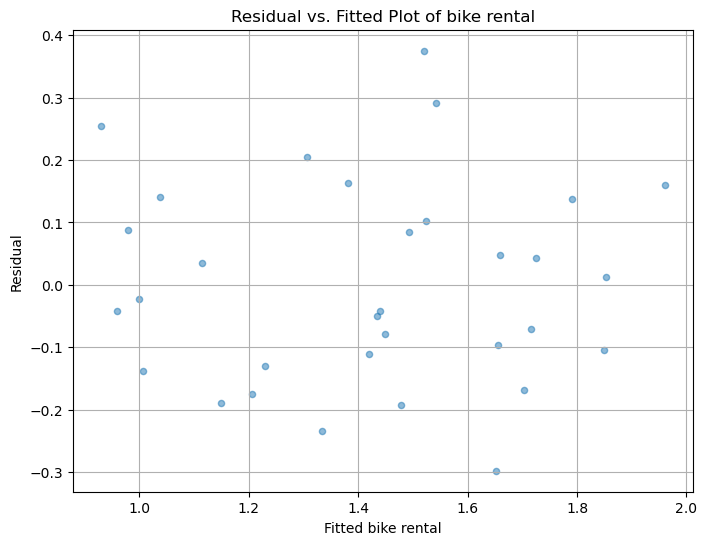

In [39]:
# Residuals vs. Fitted plot

# Set the figure size
plt.figure(figsize=(8, 6))  
# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
# s = 20: controlling the size of the markers. The default value is plt.rcParams['lines.markersize'] ** 2. Here we set it as 20.
# To get the default value of marker size, run the following line
# print(plt.rcParams['lines.markersize'] ** 2) 
plt.scatter(OLS_regression_data.fittedvalues, OLS_regression_data.resid, alpha = 0.5, s=20)
# plt.scatter(model_bike_rental.fittedvalues, model_bike_rental.resid, alpha = 0.5)
# adding title and labels
plt.xlabel('Fitted bike rental')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of bike rental')
# Adding grid lines
plt.grid(True)
plt.show()

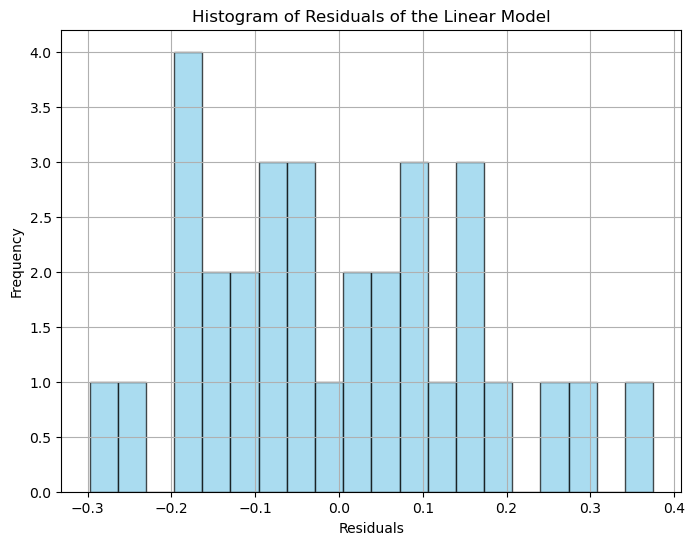

In [40]:
# Histogram of residuals

# Set the figure size
plt.figure(figsize=(8, 6))  

# Plotting the histogram
plt.hist(OLS_regression_data.resid, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals of the Linear Model')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()

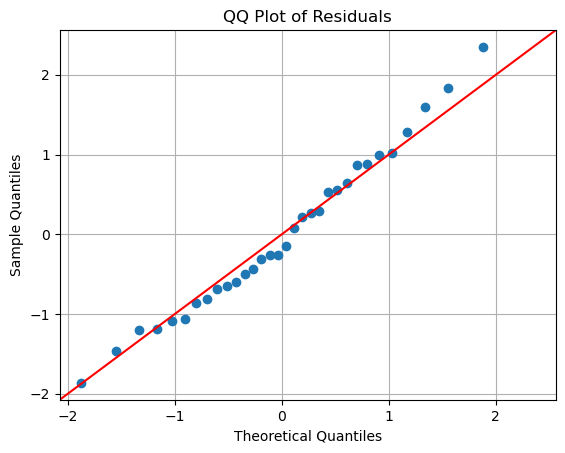

In [41]:
#the QQ plot of residuals
# More details: https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot.html
fig = sm.qqplot(OLS_regression_data.resid, fit=True, line="45")
plt.title('QQ Plot of Residuals')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()

## Statistical tests of the four conditions

### Linear relationship

In [44]:
test_rainbow = statsmodels.stats.diagnostic.linear_rainbow(OLS_regression_data)
# This function returns a tuple consisting of two values: the test statistic based on the F test and the pvalue of the test
# Note that these two values are not named. Therefore, you need to know the order before accessing these two values.
print("The p value of the rainbow test: {:.4f}".format(test_rainbow[1]))

The p value of the rainbow test: 0.6549


As the p value is greater than 0.05, we can not reject the null hypothesis, which means that residuals are homoskedastic and would indicate that this dataset and model does meet the linear relationship condition.

In [45]:
test_dw = statsmodels.stats.stattools.durbin_watson(OLS_regression_data.resid)
print("Durbin-Watson test statistic is: {:.4f}".format(test_dw))

Durbin-Watson test statistic is: 1.5974


Empirically, if the test statistic is between 1 and 2, it is likely that there is no serial correlation in the residuals. Considering the results of 1.59 we can say that residuals are independent.

In [46]:
test_JB = statsmodels.stats.stattools.jarque_bera(OLS_regression_data.resid)
print("The p value of the Jarque Bera test: {:.4f}".format(test_JB[1]))

The p value of the Jarque Bera test: 0.5960


As the p value is greater than 0.05, we can not reject the null hypothesis, so we conclude that the residuals are normally distributed.

In [47]:
statsmodels.stats.diagnostic.het_goldfeldquandt(OLS_regression_data.model.endog, OLS_regression_data.model.exog)

(np.float64(0.7462712623733826), np.float64(0.6821138615852991), 'increasing')

As the p-value is greater than 0.05 we can not reject the null hypothesis and we can conclude that there is equal variance.